In [28]:
import numpy as np
import yfinance as yf
import pandas as pd
from datetime import datetime
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math
import matplotlib.pyplot as plt
import joblib

In [5]:
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout
from tensorflow.keras.callbacks import EarlyStopping

In [7]:
nse_stocks = [
    "RELIANCE.NS",   # Reliance Industries Limited
    "TCS.NS",        # Tata Consultancy Services
    "HDFCBANK.NS",   # HDFC Bank Limited
    "INFY.NS",       # Infosys Limited
    "ICICIBANK.NS",  # ICICI Bank Limited
    "KOTAKBANK.NS",  # Kotak Mahindra Bank Limited
    "HINDUNILVR.NS", # Hindustan Unilever Limited
    "LT.NS",         # Larsen & Toubro Limited
    "SBIN.NS",       # State Bank of India
    "BHARTIARTL.NS", # Bharti Airtel Limited
    "ITC.NS",        # ITC Limited
    "BAJFINANCE.NS", # Bajaj Finance Limited
    "AXISBANK.NS",   # Axis Bank Limited
    "HCLTECH.NS",    # HCL Technologies Limited
    "MARUTI.NS",     # Maruti Suzuki India Limited
    "M&M.NS",        # Mahindra & Mahindra Limited
    "ASIANPAINT.NS", # Asian Paints Limited
    "NESTLEIND.NS",  # Nestlé India Limited
    "ULTRACEMCO.NS", # UltraTech Cement Limited
    "SUNPHARMA.NS",  # Sun Pharmaceutical Industries Limited
    "TITAN.NS",      # Titan Company Limited
    "DRREDDY.NS",    # Dr. Reddy's Laboratories Limited
    "WIPRO.NS",      # Wipro Limited
    "ADANIPORTS.NS", # Adani Ports and Special Economic Zone Limited
    "POWERGRID.NS",  # Power Grid Corporation of India Limited
    "GRASIM.NS",     # Grasim Industries Limited
    "NTPC.NS",       # NTPC Limited
    "ONGC.NS",       # Oil and Natural Gas Corporation Limited
    "INDUSINDBK.NS", # IndusInd Bank Limited
    "BAJAJFINSV.NS"  # Bajaj Finserv Limited
]

In [8]:
start_date = "2019-01-01"
end_date = str(datetime.now().date())

dfs = {}

In [9]:
for ticker in nse_stocks:
    df = yf.download(ticker, start=start_date, end=end_date)
    df.reset_index(inplace=True)
    dfs[ticker] = df

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%********

In [10]:
for ticker in nse_stocks:
    dfs[ticker] = dfs[ticker][['Date', 'Close']]

In [18]:
WINDOW_SIZE = 45

In [19]:
def create_stock_sequences(df, sequence_length=WINDOW_SIZE):
    df_copy = df.copy()
    
    scaler = MinMaxScaler(feature_range=(0, 1))
    df_copy['Close_scaled'] = scaler.fit_transform(df_copy[['Close']])
    
    close_prices = df_copy['Close_scaled'].values
    
    X, y = [], []
    for i in range(sequence_length, len(close_prices)):
        X.append(close_prices[i-sequence_length:i])
        y.append(close_prices[i])
    
    X = np.array(X)
    y = np.array(y)
    
    X = np.reshape(X, (X.shape[0], X.shape[1], 1))
    
    dates = df_copy['Date'].values[sequence_length:]
    
    return X, y, scaler, dates

In [12]:
stock_sequences = {}

for ticker, df in dfs.items():
    df = df[['Date', 'Close']]
    
    X, y, scaler, dates = create_stock_sequences(df, sequence_length=60)
    
    stock_sequences[ticker] = {
        'X': X,
        'y': y,
        'scaler': scaler,
        'dates': dates
    }
    
    print(f"{ticker} - X shape: {X.shape}, y shape: {y.shape}")


RELIANCE.NS - X shape: (1450, 60, 1), y shape: (1450,)
TCS.NS - X shape: (1450, 60, 1), y shape: (1450,)
HDFCBANK.NS - X shape: (1449, 60, 1), y shape: (1449,)
INFY.NS - X shape: (1450, 60, 1), y shape: (1450,)
ICICIBANK.NS - X shape: (1450, 60, 1), y shape: (1450,)
KOTAKBANK.NS - X shape: (1449, 60, 1), y shape: (1449,)
HINDUNILVR.NS - X shape: (1450, 60, 1), y shape: (1450,)
LT.NS - X shape: (1450, 60, 1), y shape: (1450,)
SBIN.NS - X shape: (1450, 60, 1), y shape: (1450,)
BHARTIARTL.NS - X shape: (1449, 60, 1), y shape: (1449,)
ITC.NS - X shape: (1450, 60, 1), y shape: (1450,)
BAJFINANCE.NS - X shape: (1450, 60, 1), y shape: (1450,)
AXISBANK.NS - X shape: (1450, 60, 1), y shape: (1450,)
HCLTECH.NS - X shape: (1449, 60, 1), y shape: (1449,)
MARUTI.NS - X shape: (1449, 60, 1), y shape: (1449,)
M&M.NS - X shape: (1450, 60, 1), y shape: (1450,)
ASIANPAINT.NS - X shape: (1449, 60, 1), y shape: (1449,)
NESTLEIND.NS - X shape: (1450, 60, 1), y shape: (1450,)
ULTRACEMCO.NS - X shape: (1450,

In [13]:
def build_model(input_shape):
    model = Sequential()
    
    model.add(LSTM(units=50, return_sequences=True, input_shape=input_shape))
    model.add(Dropout(0.2))
    
    model.add(LSTM(units=50, return_sequences=True))
    model.add(Dropout(0.2))
    
    model.add(LSTM(units=50))
    model.add(Dropout(0.2))

    model.add(Dense(units=1))
    
    model.compile(optimizer='adam', loss='mean_squared_error')
    
    return model

In [14]:
early_stop = EarlyStopping(monitor='loss', patience=5, restore_best_weights=True)

In [ ]:
X_train = stock_sequences["AXISBANK.NS"]['X']
y_train = stock_sequences["AXISBANK.NS"]['y']

model = build_model((X_train.shape[1], X_train.shape[2]))

history = model.fit(
    X_train,
    y_train,
    epochs=50,
    batch_size=32,
    verbose=1,
    callbacks=[early_stop]
)

print(f"Finished training model for RELIANCE.NS")

In [32]:
models = {}

for ticker, data in stock_sequences.items():
    X_train = data['X']
    y_train = data['y']
    
    model = build_model((X_train.shape[1], X_train.shape[2]))
    
    history = model.fit(
        X_train,
        y_train,
        epochs=50,
        batch_size=32,
        verbose=1,
        callbacks=[early_stop]
    )
    
    models[ticker] = model
    
    print(f"Finished training model for {ticker}")

Epoch 1/50
46/46 [==============================] - 14s 85ms/step - loss: 0.0408
Epoch 2/50
46/46 [==============================] - 4s 80ms/step - loss: 0.0055
Epoch 3/50
46/46 [==============================] - 4s 78ms/step - loss: 0.0048
Epoch 4/50
46/46 [==============================] - 4s 79ms/step - loss: 0.0042
Epoch 5/50
46/46 [==============================] - 4s 78ms/step - loss: 0.0043
Epoch 6/50
46/46 [==============================] - 4s 80ms/step - loss: 0.0043
Epoch 7/50
46/46 [==============================] - 4s 88ms/step - loss: 0.0040
Epoch 8/50
46/46 [==============================] - 4s 80ms/step - loss: 0.0039
Epoch 9/50
46/46 [==============================] - 4s 86ms/step - loss: 0.0037
Epoch 10/50
46/46 [==============================] - 4s 84ms/step - loss: 0.0035
Epoch 11/50
46/46 [==============================] - 4s 81ms/step - loss: 0.0036
Epoch 12/50
46/46 [==============================] - 4s 81ms/step - loss: 0.0035
Epoch 13/50
46/46 [=================

In [27]:
joblib.dump(models, 'best_models.pkl')
print("Models have been saved to 'best_models.pkl'.")

Models have been saved to 'best_models.pkl'.


1/1 [==============================] - 0s 34ms/step


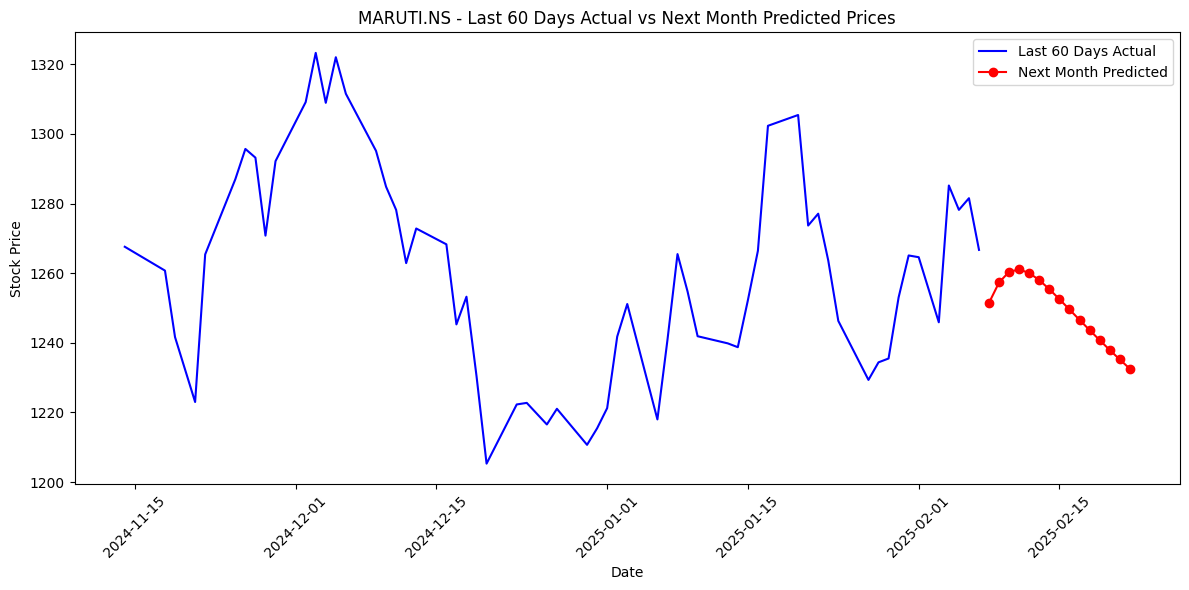

In [ ]:
data = stock_sequences["RELIANCE.NS"]
scaler = data['scaler']
dates = data['dates']
X_train = data['X']
y_train = data['y']

last_sequence = X_train[-1]

num_future_days = 15

future_predictions_scaled = []
last_date = pd.to_datetime(dates[-1])
future_dates = []

current_sequence = last_sequence.copy()

for i in range(num_future_days):
    current_sequence_reshaped = current_sequence.reshape(1, current_sequence.shape[0], 1)
    next_pred_scaled = model.predict(current_sequence_reshaped)
    future_predictions_scaled.append(next_pred_scaled[0, 0])
    current_sequence = np.append(current_sequence[1:], [[next_pred_scaled[0, 0]]], axis=0)
    last_date = last_date + pd.Timedelta(days=1)
    future_dates.append(last_date)

future_predictions_scaled = np.array(future_predictions_scaled)
future_predictions = scaler.inverse_transform(future_predictions_scaled.reshape(-1, 1))

last_60_actual_scaled = y_train[-60:]
last_60_actual = scaler.inverse_transform(last_60_actual_scaled.reshape(-1, 1))
last_60_dates = pd.to_datetime(dates[-60:])

plt.figure(figsize=(12, 6))
plt.plot(last_60_dates, last_60_actual, label="Last 60 Days Actual", color='blue')
plt.plot(future_dates, future_predictions, label="Next Month Predicted", color='red', marker='o')
plt.xlabel("Date")
plt.ylabel("Stock Price")
plt.title(f"{ticker} - Last 60 Days Actual vs Next Month Predicted Prices")
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

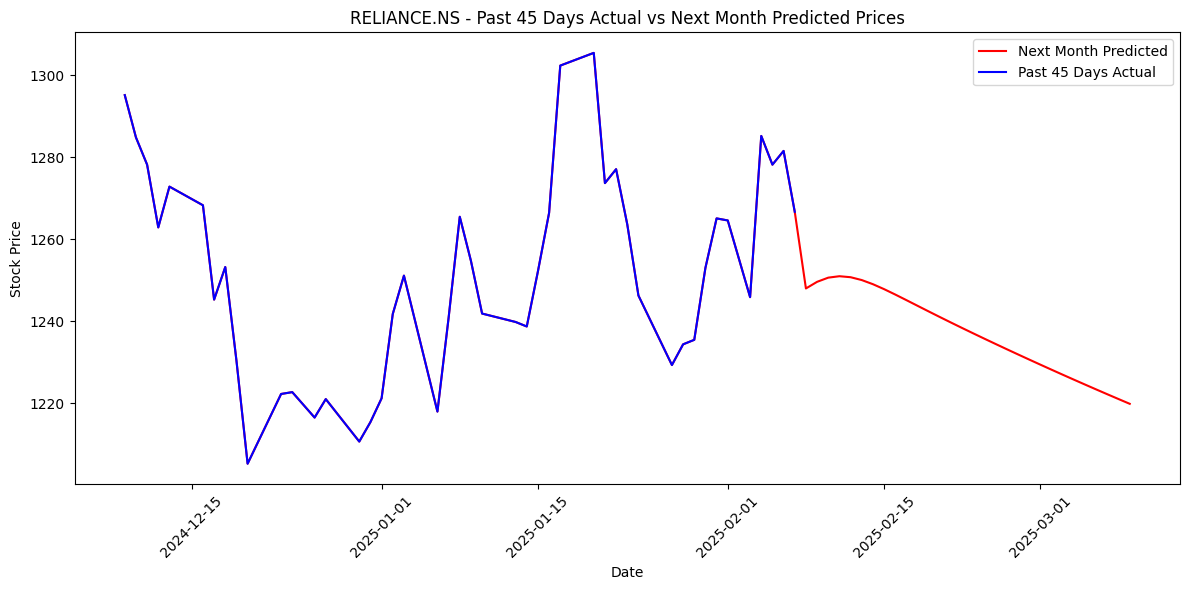

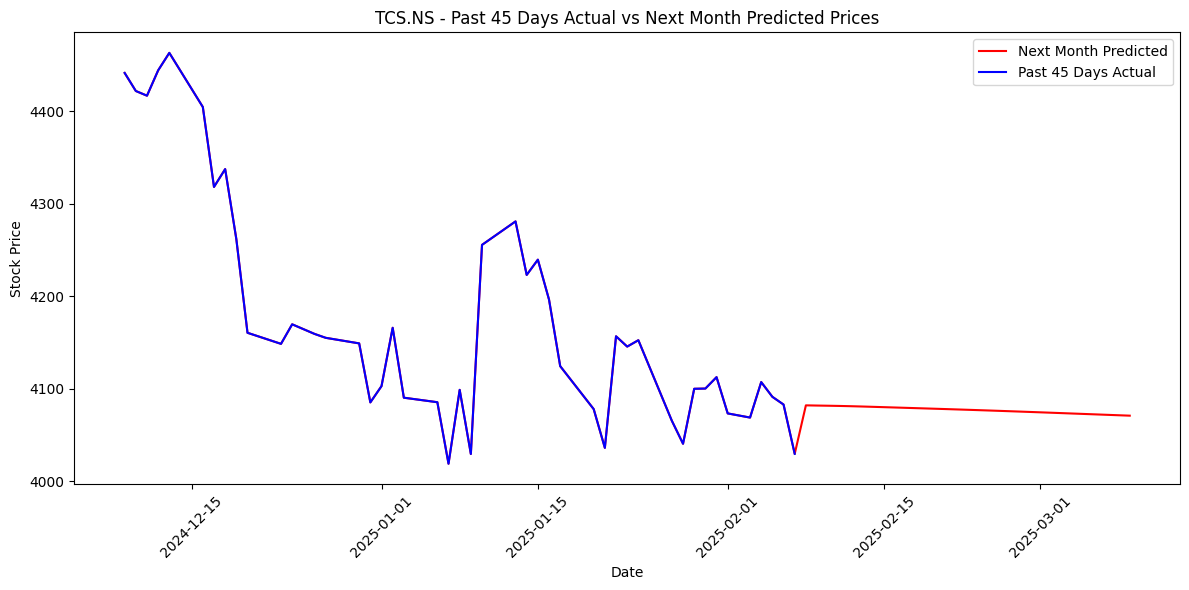

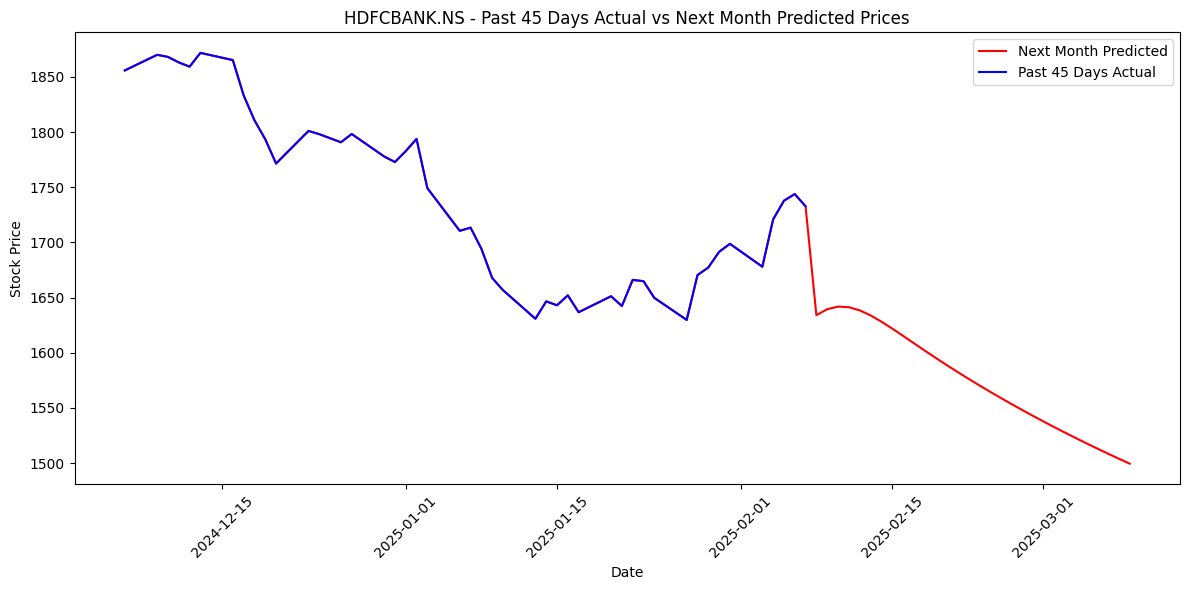

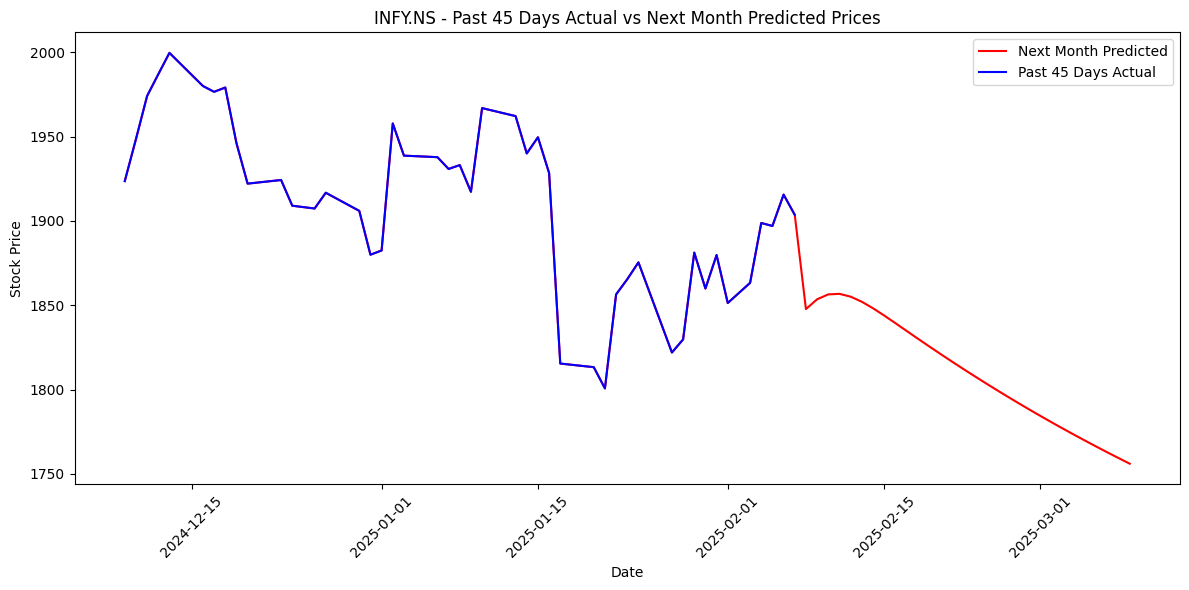

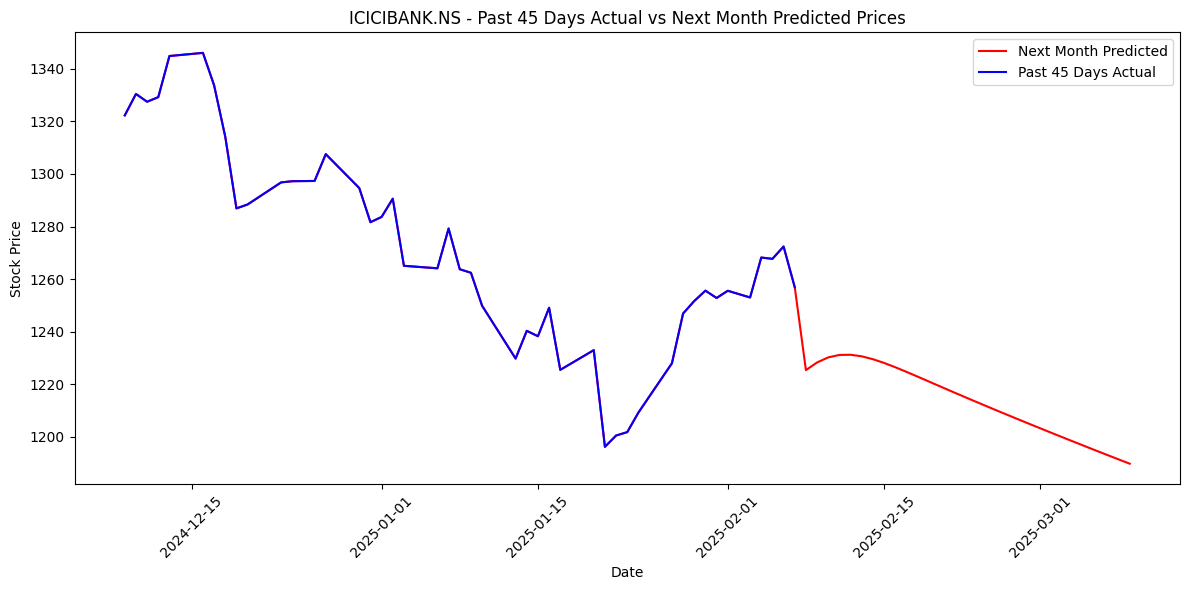

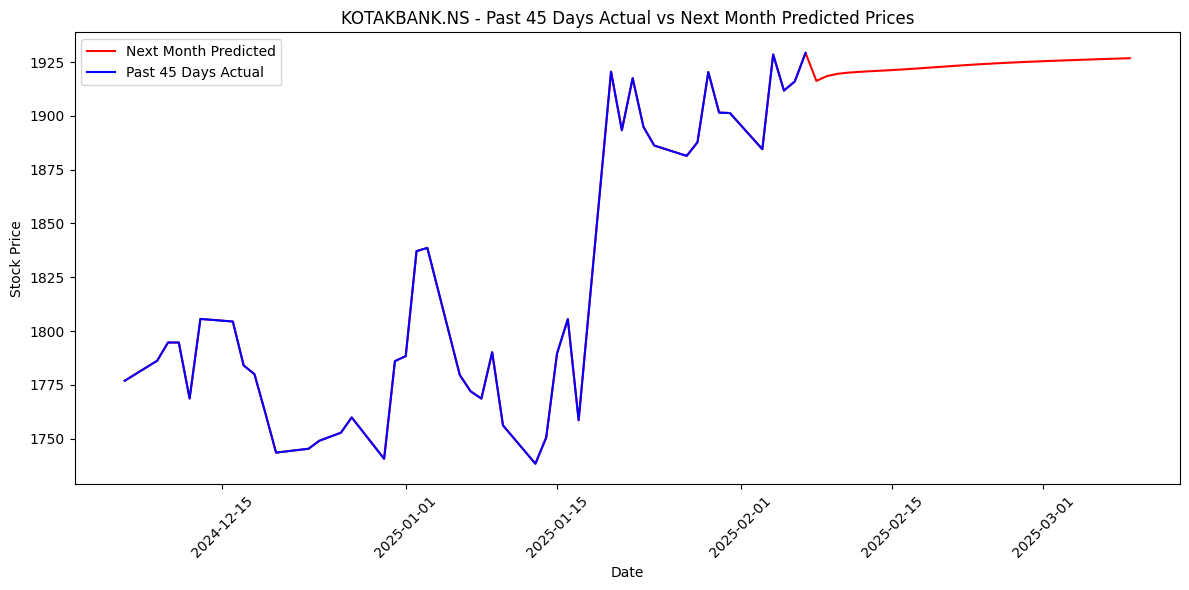

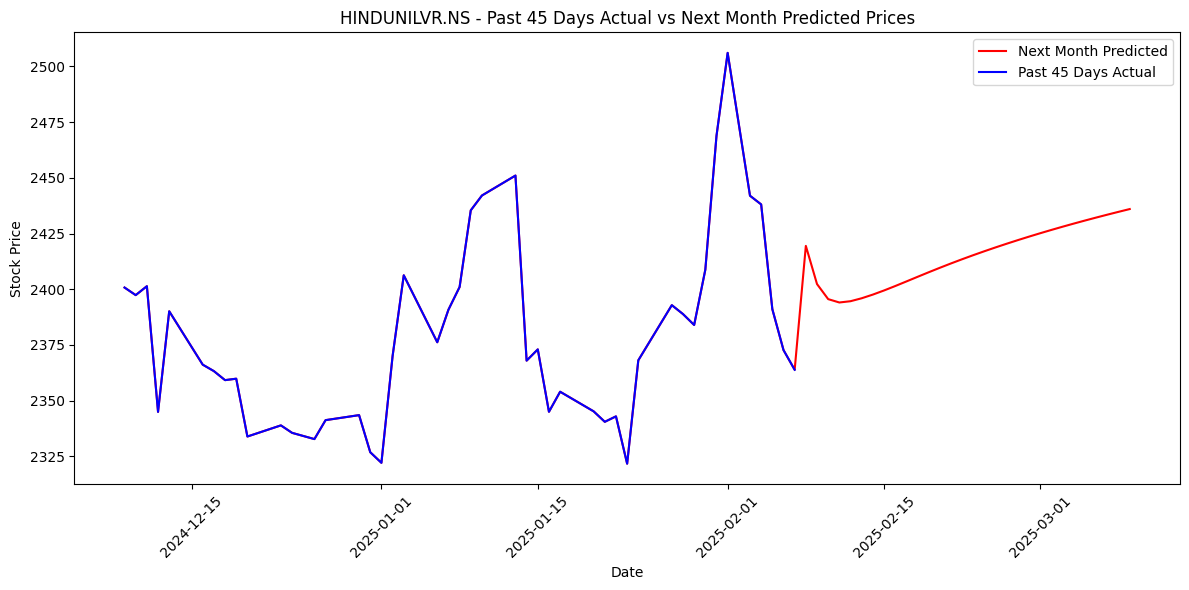

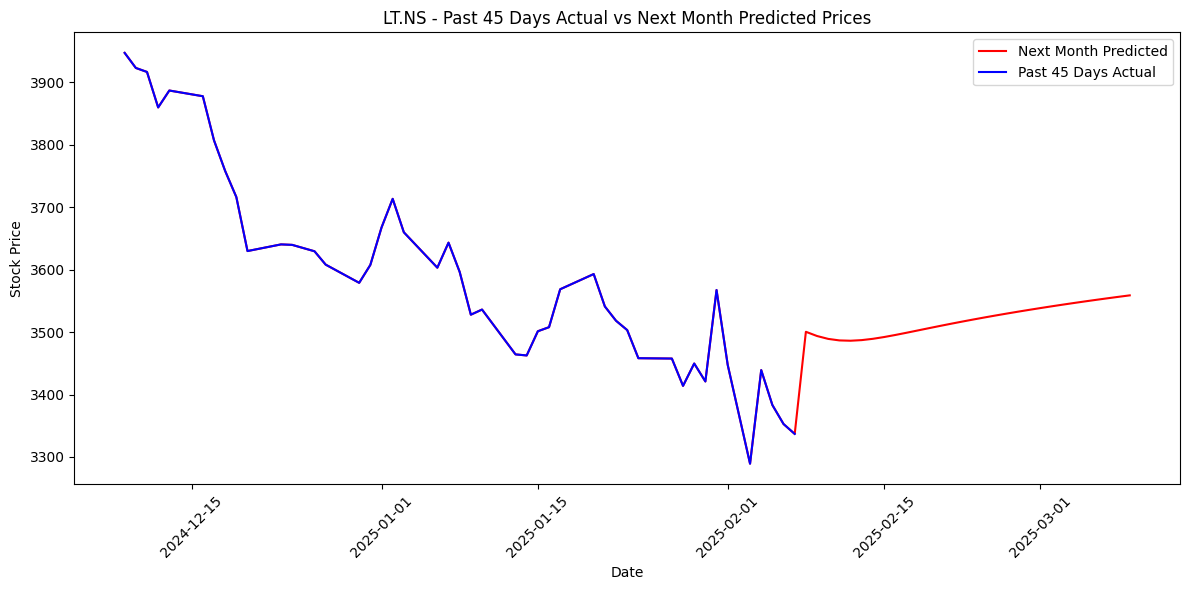

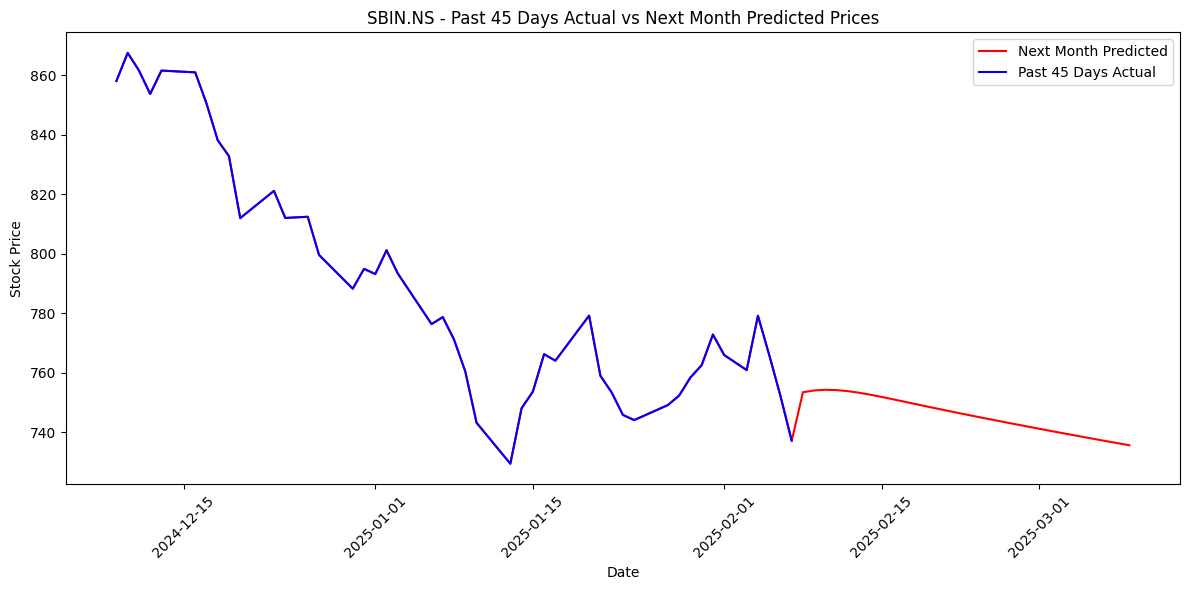

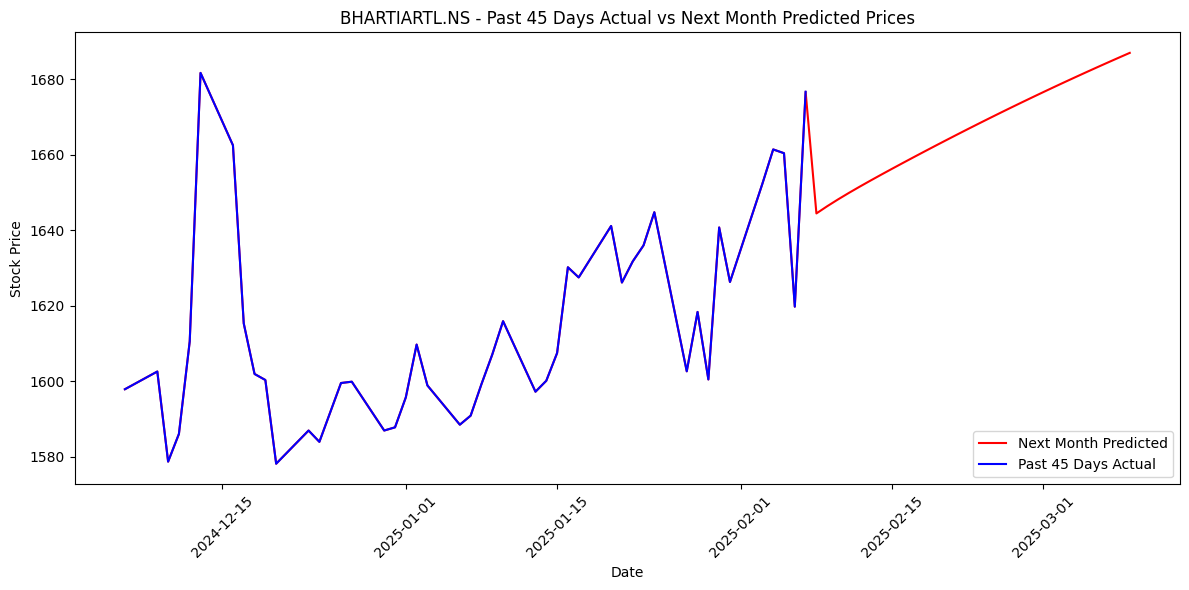

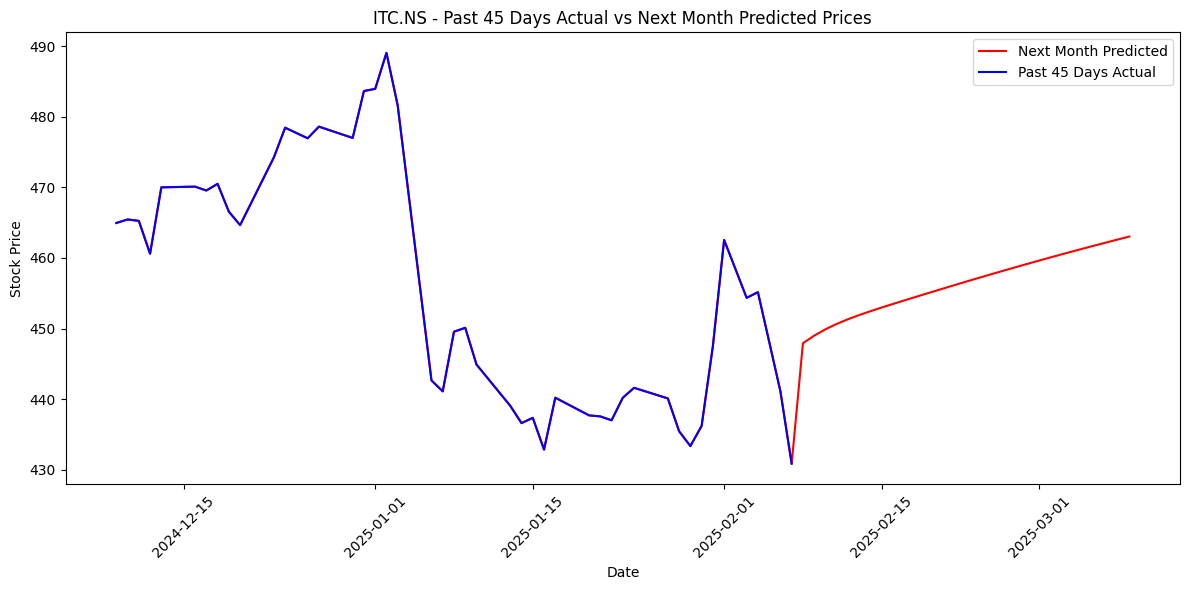

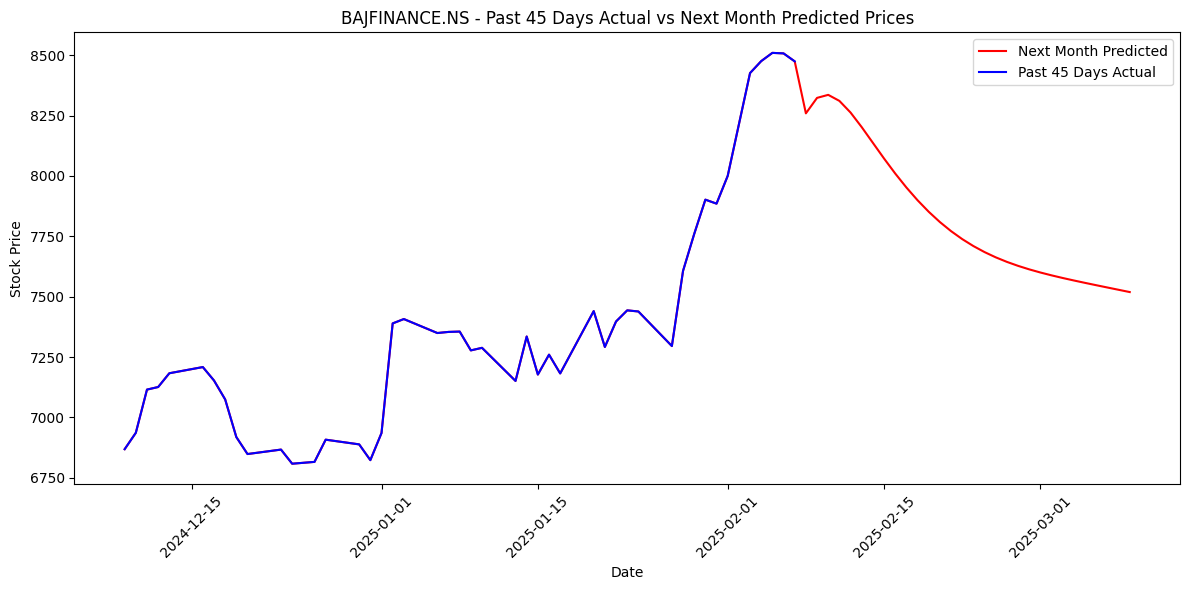

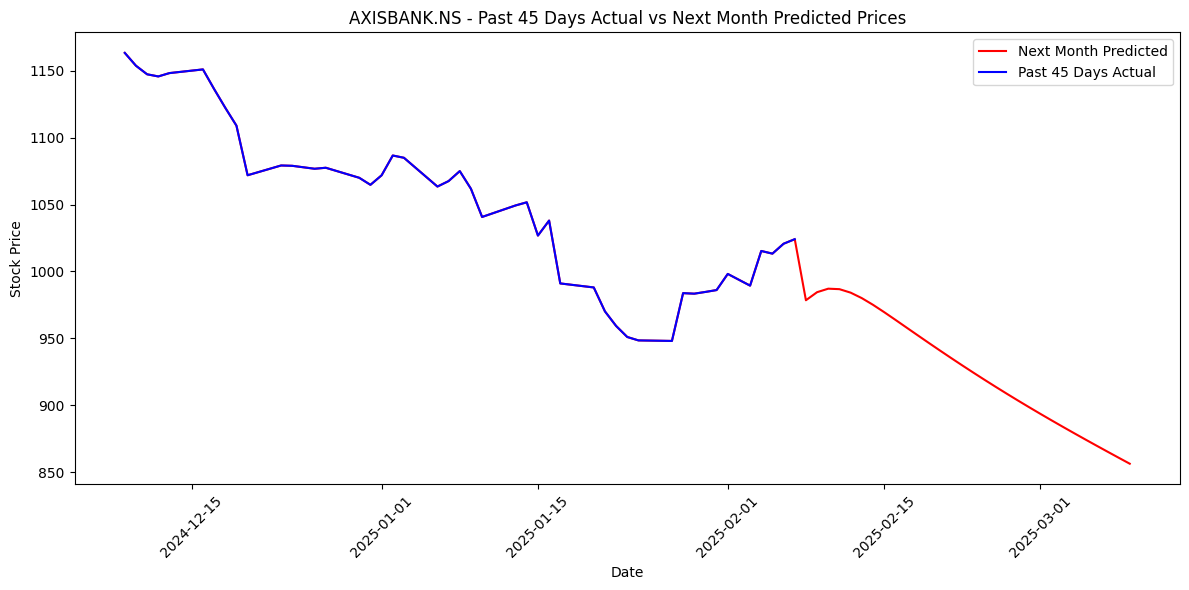

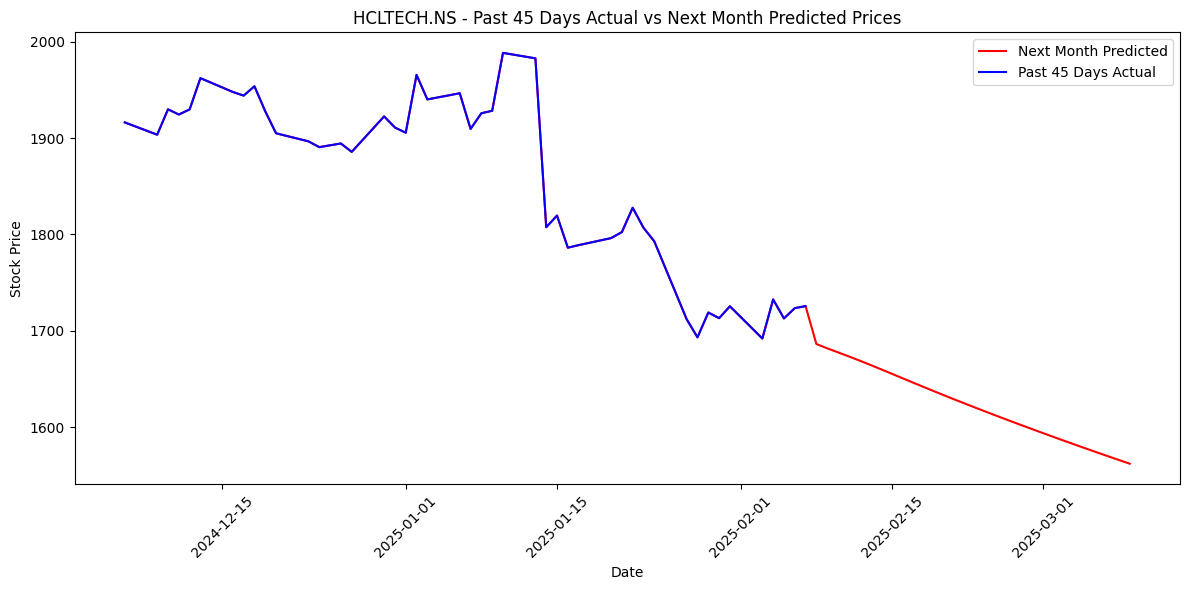

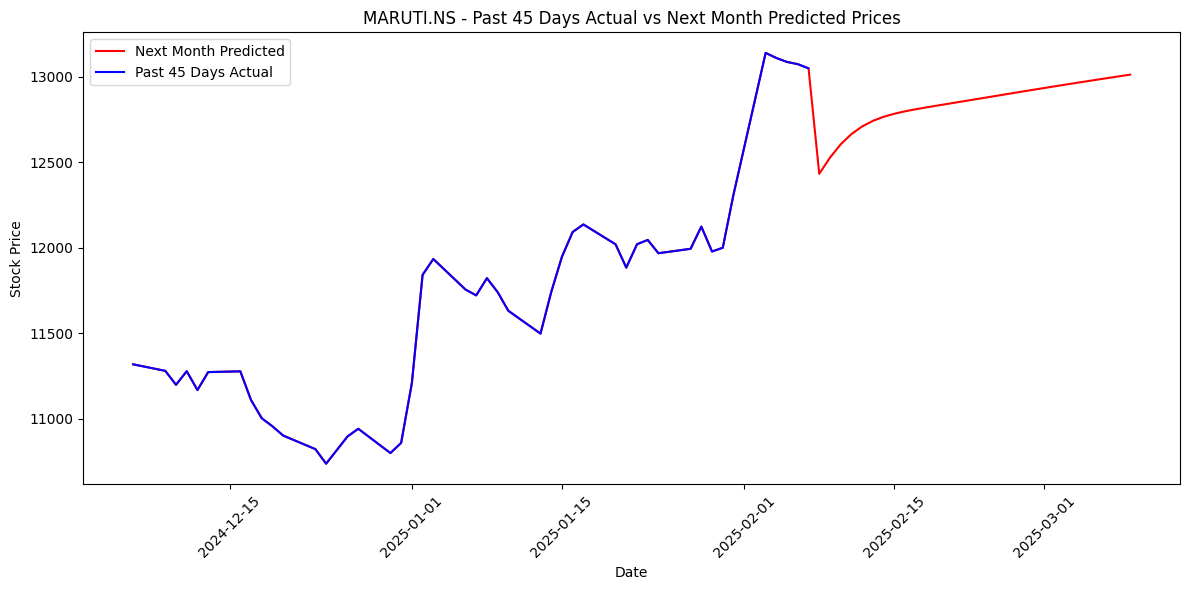

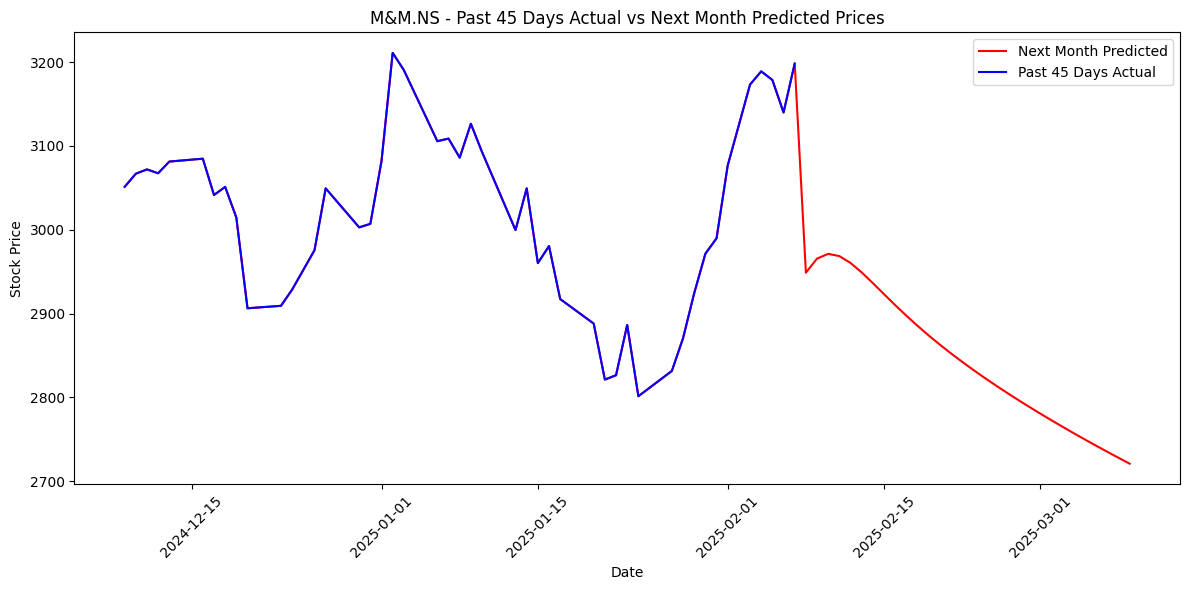

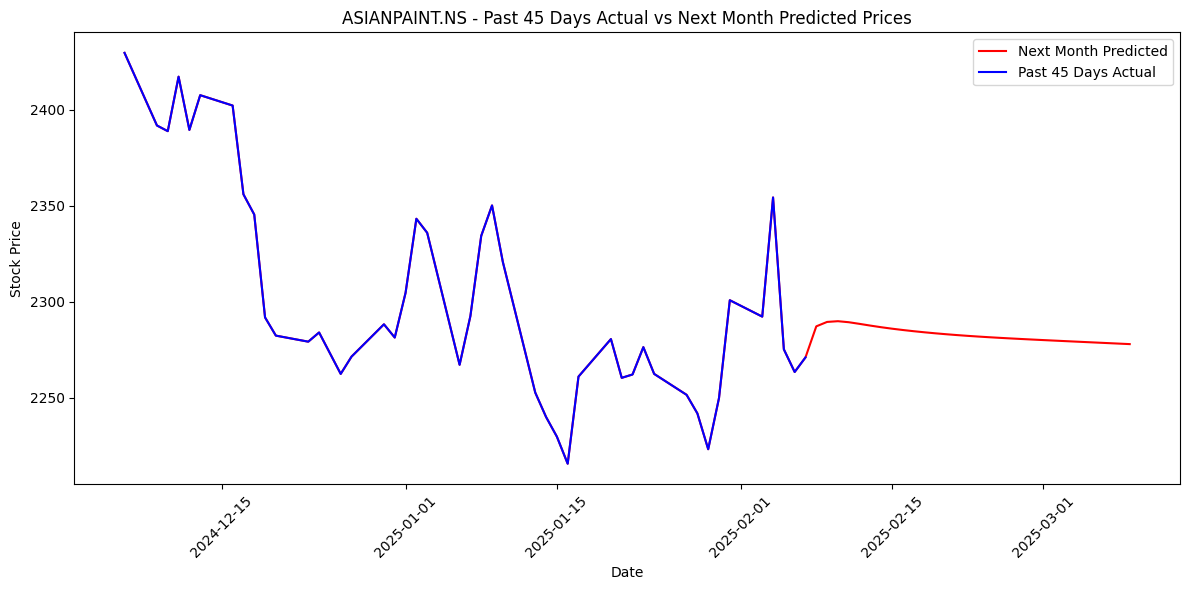

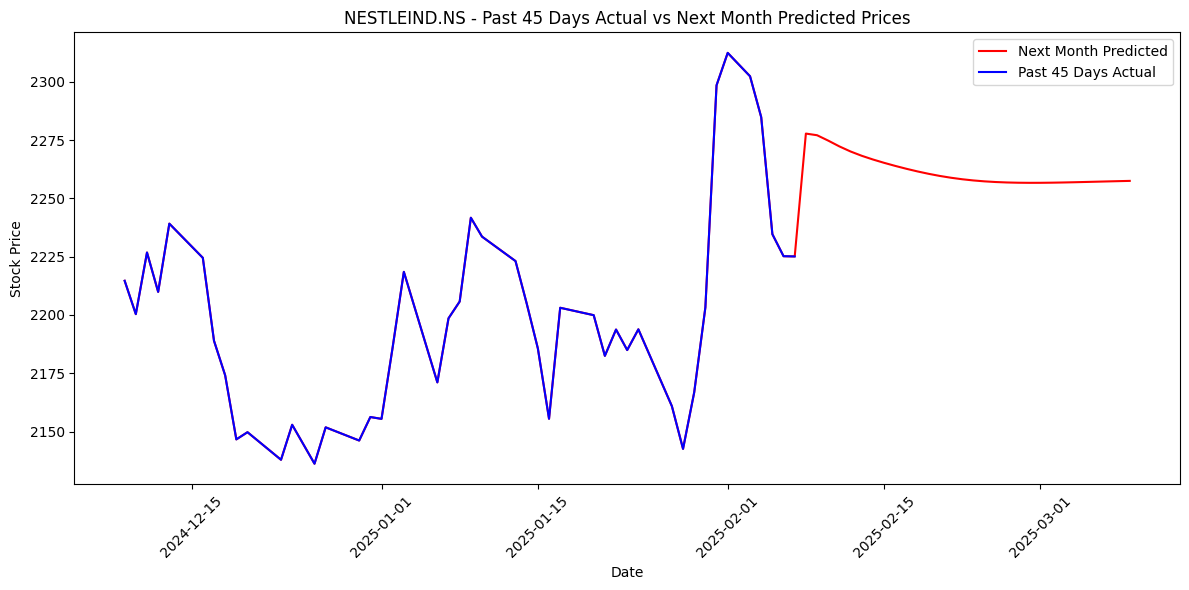

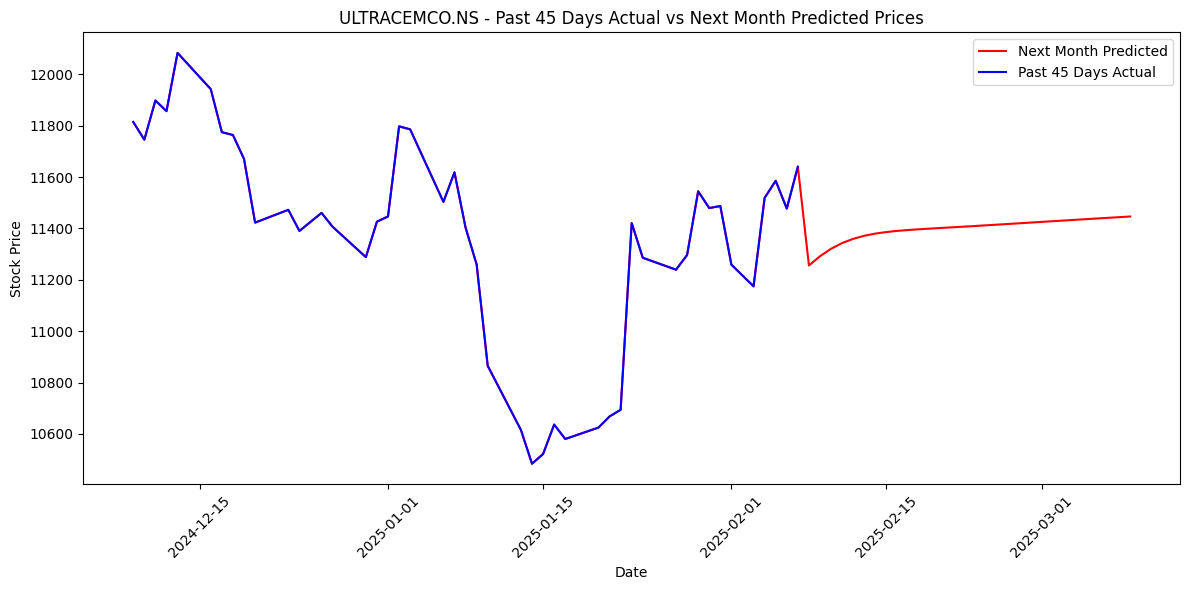

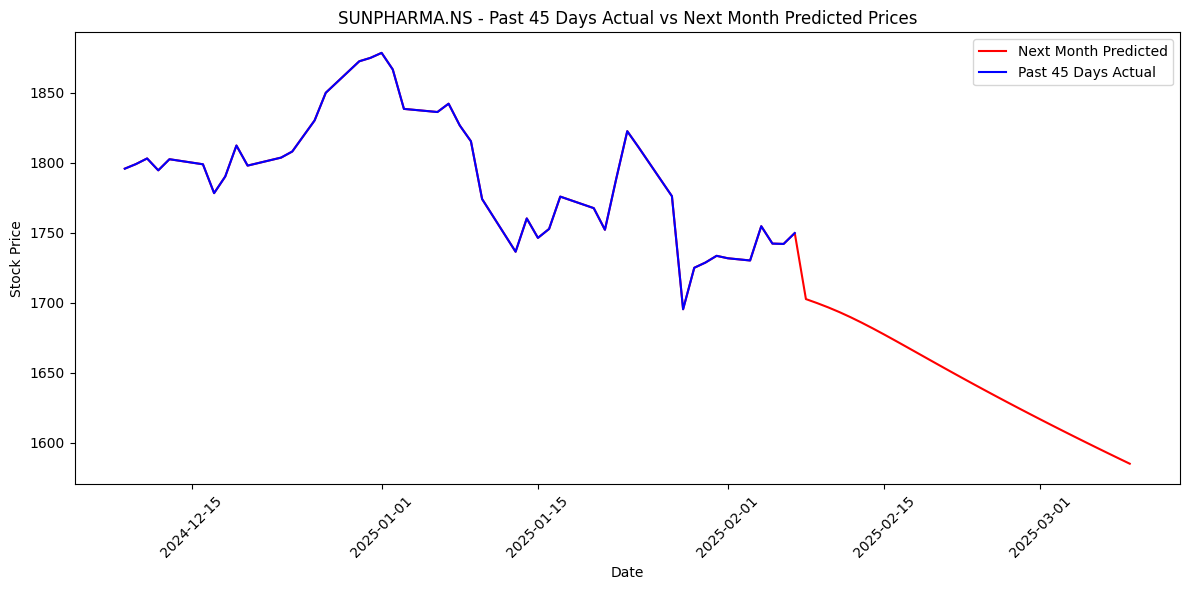

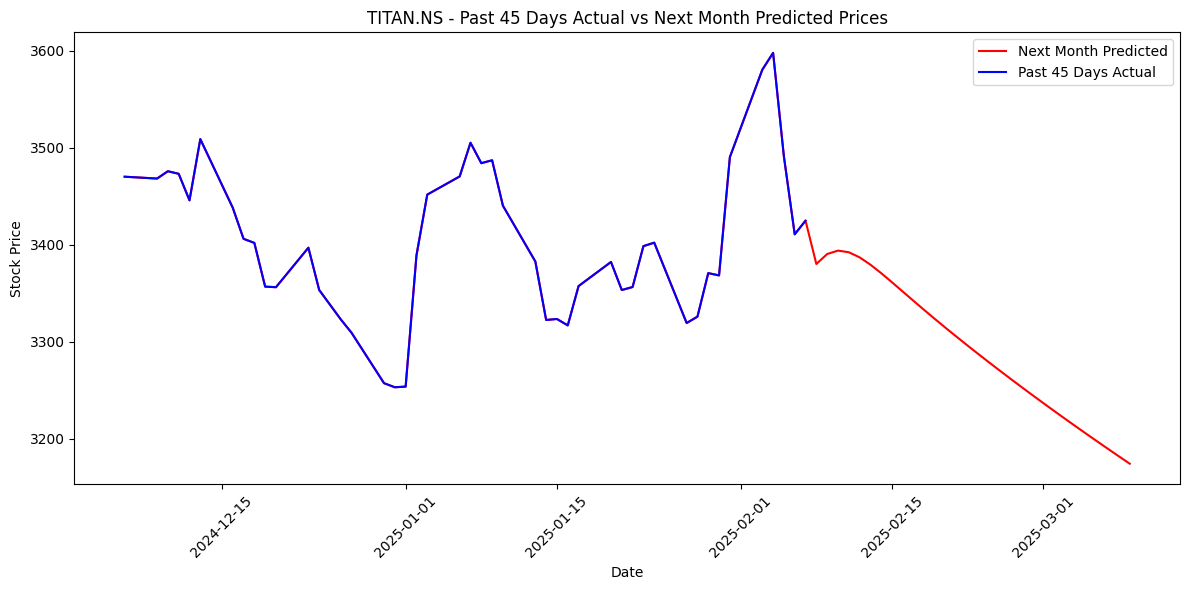

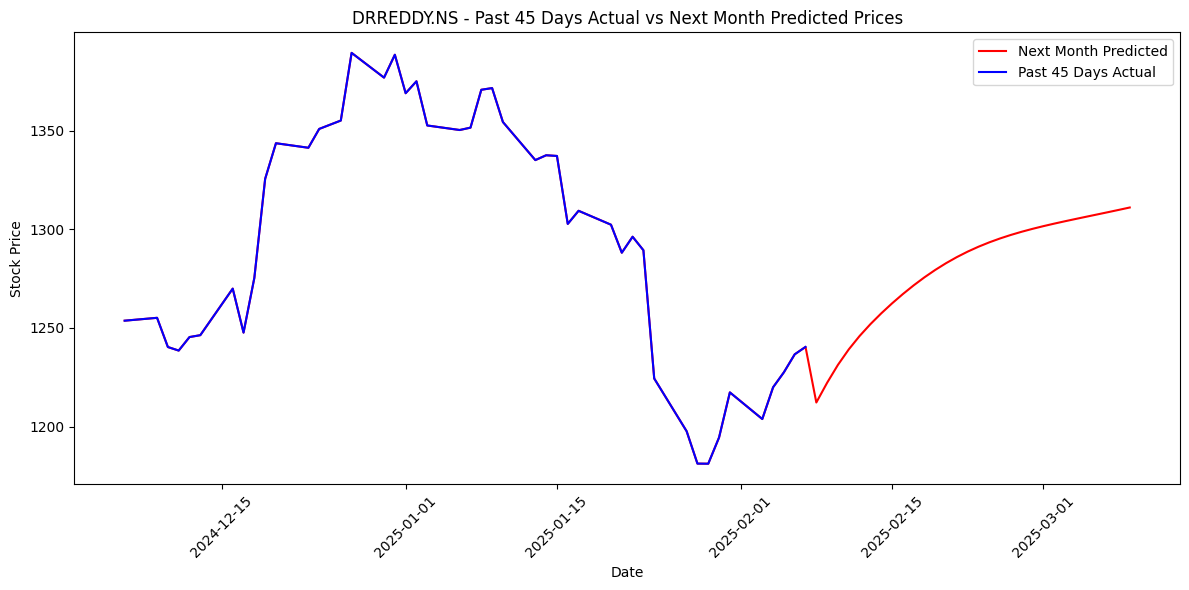

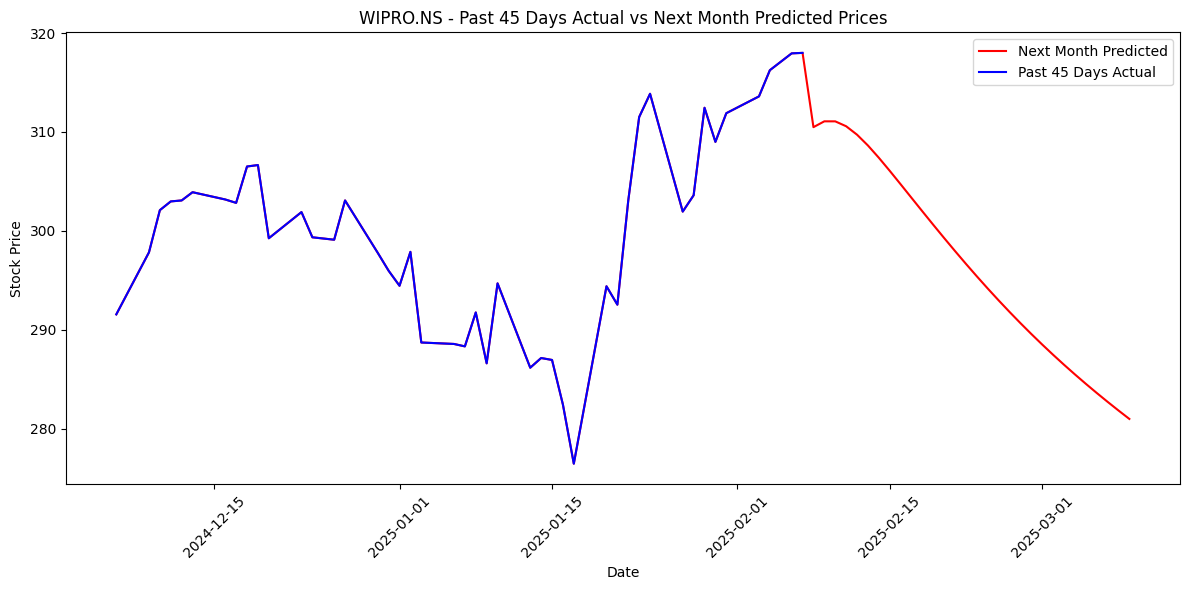

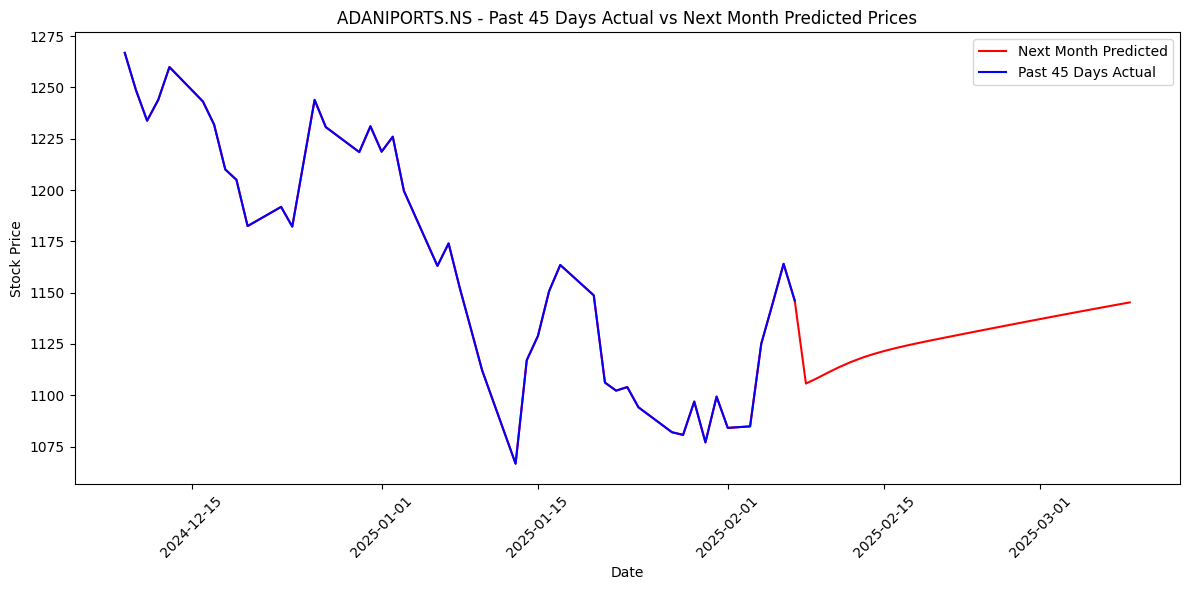

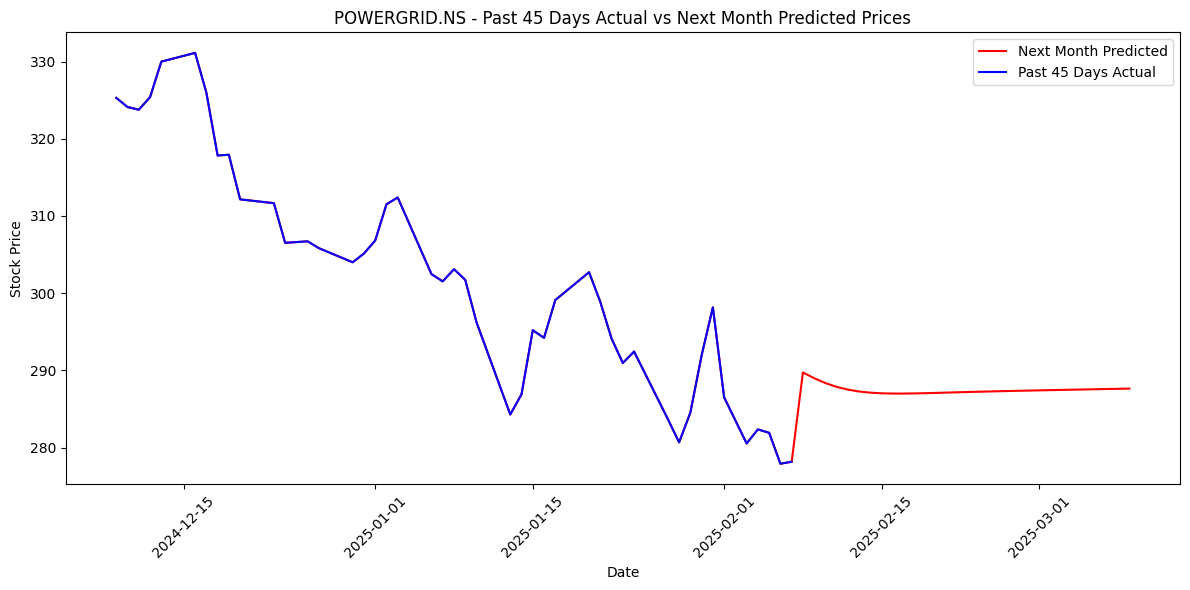

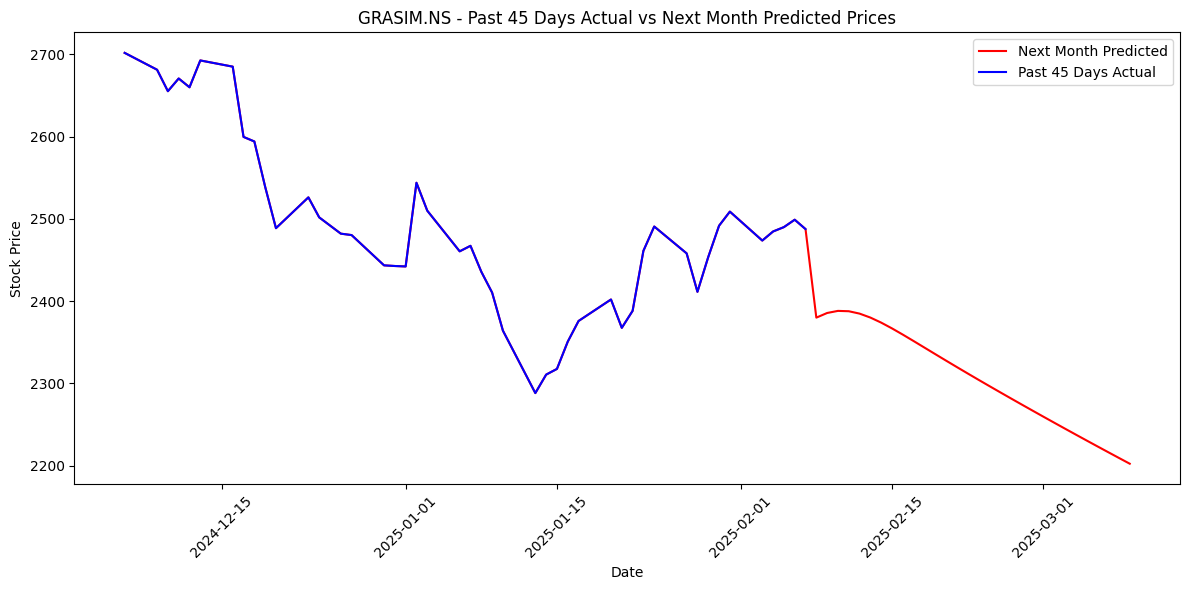

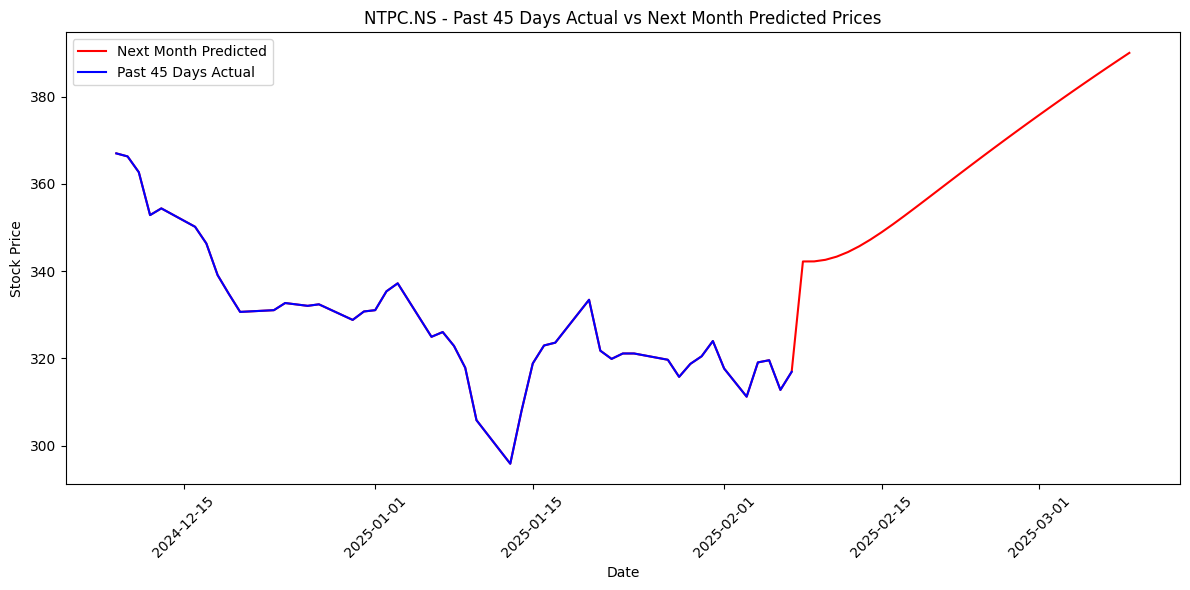

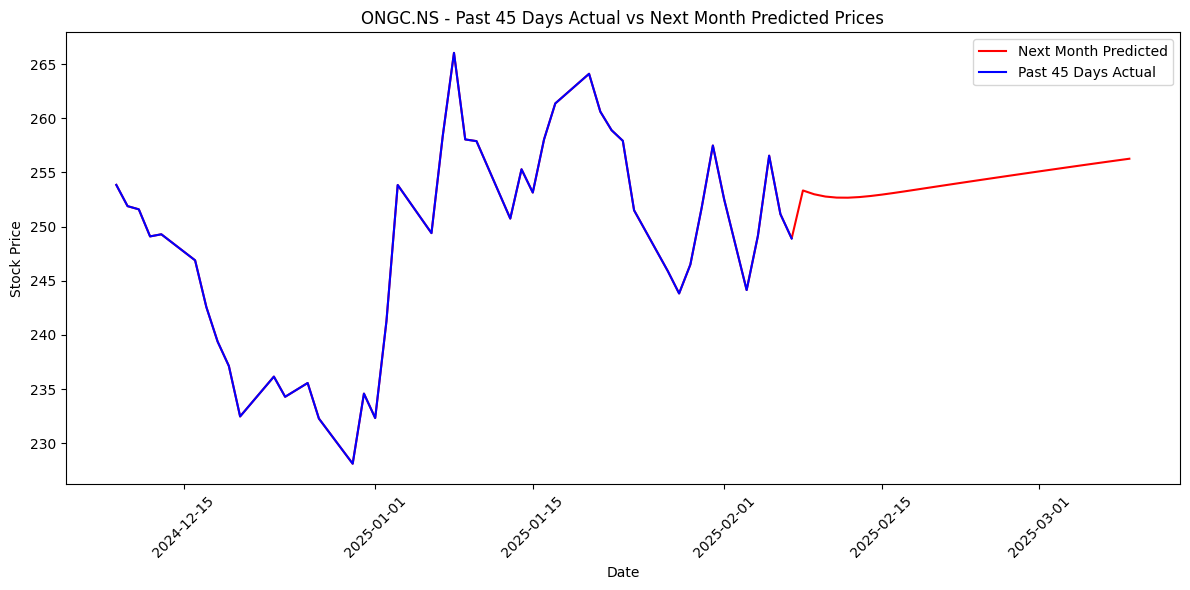

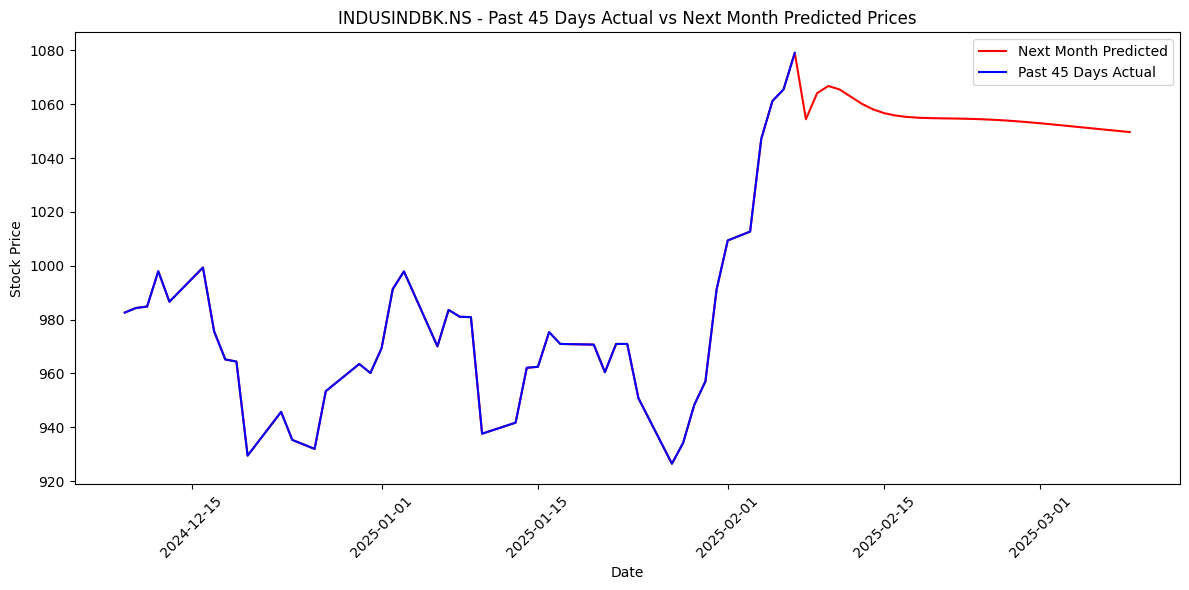

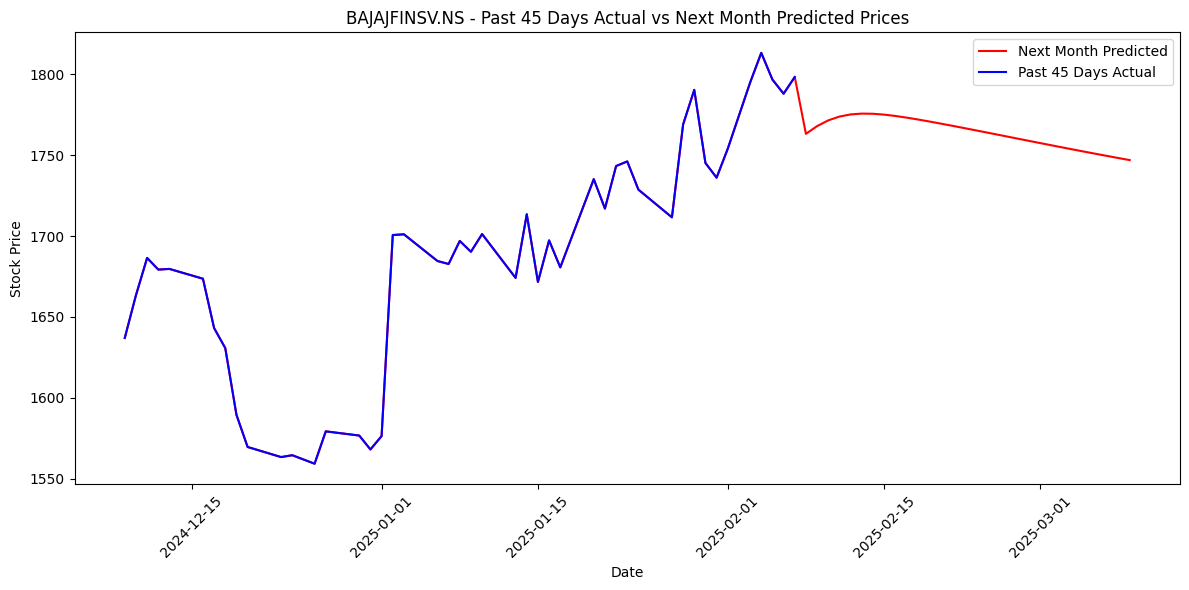

In [25]:
for ticker, data in stock_sequences.items():
    model = models[ticker]
    scaler = data['scaler']
    dates = data['dates']
    X = data['X']
    y = data['y']    
    
    past_actual_dates = pd.to_datetime(dates[-45:])
    actual_scaled = y[-45:]
    past_actual_values = scaler.inverse_transform(actual_scaled.reshape(-1, 1))
    
    last_sequence = X[-1]
    
    future_predictions_scaled = []
    future_dates = []
    
    last_date = pd.to_datetime(dates[-1])
    
    current_sequence = last_sequence.copy()
    
    for i in range(30):
        current_sequence_reshaped = current_sequence.reshape(1, current_sequence.shape[0], 1)
        next_pred_scaled = model.predict(current_sequence_reshaped, verbose=0)
        future_predictions_scaled.append(next_pred_scaled[0, 0])
        
        current_sequence = np.append(current_sequence[1:], [[next_pred_scaled[0, 0]]], axis=0)
        
        last_date = last_date + pd.Timedelta(days=1)
        future_dates.append(last_date)
    
    future_predictions = scaler.inverse_transform(np.array(future_predictions_scaled).reshape(-1, 1))

    combined_dates = np.concatenate([past_actual_dates, np.array(future_dates)])
    combined_dates = pd.to_datetime(combined_dates).to_pydatetime()
    combined_values = np.concatenate([past_actual_values, future_predictions])
    
    plt.figure(figsize=(12, 6))
    plt.plot(combined_dates, combined_values, color='red', label='Next Month Predicted')
    plt.plot(past_actual_dates, past_actual_values, label='Past 45 Days Actual', color='blue')
    plt.title(f"{ticker} - Past 45 Days Actual vs Next Month Predicted Prices")
    plt.xlabel("Date")
    plt.ylabel("Stock Price")
    plt.xticks(rotation=45)
    plt.legend()
    plt.tight_layout()
    plt.show()

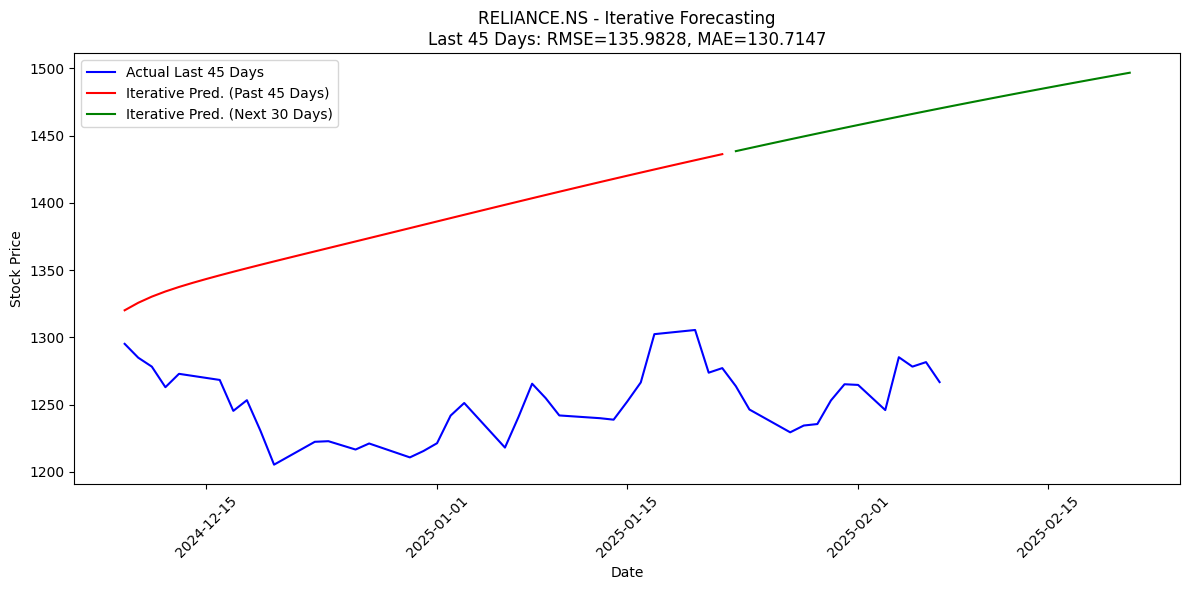

RELIANCE.NS - Last 45 Days Prediction Errors: RMSE = 135.9828, MAE = 130.7147


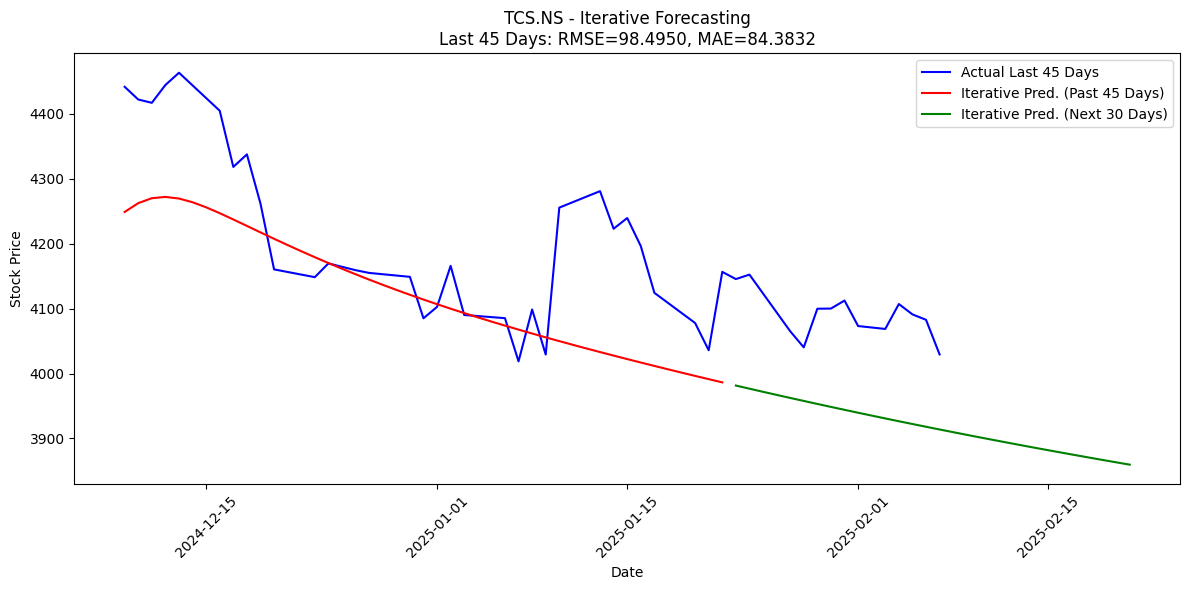

TCS.NS - Last 45 Days Prediction Errors: RMSE = 98.4950, MAE = 84.3832


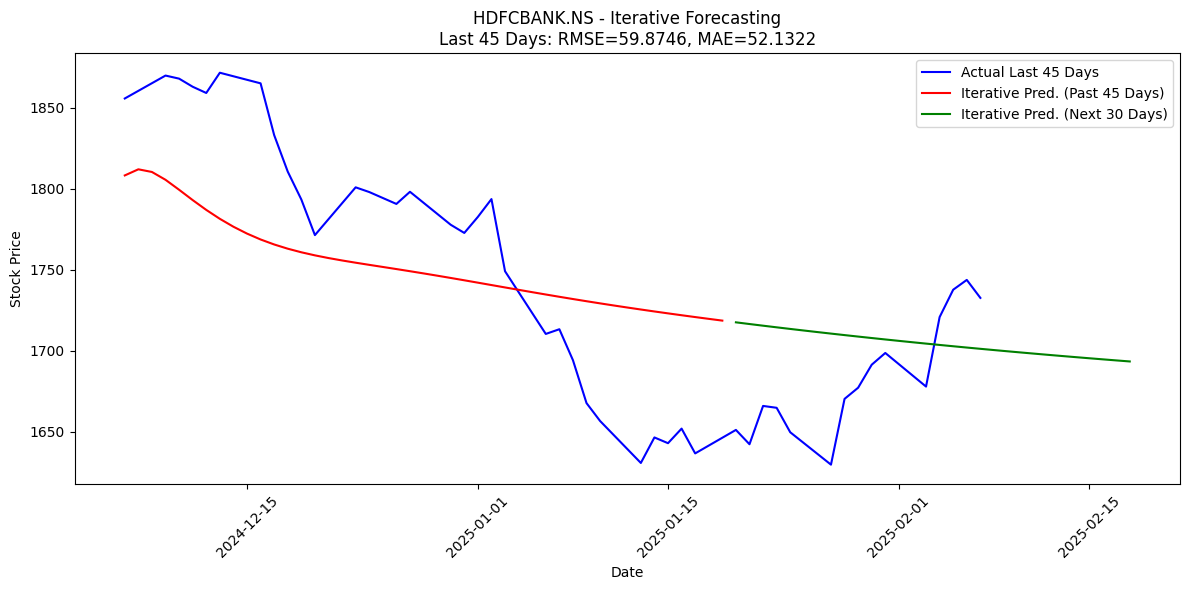

HDFCBANK.NS - Last 45 Days Prediction Errors: RMSE = 59.8746, MAE = 52.1322


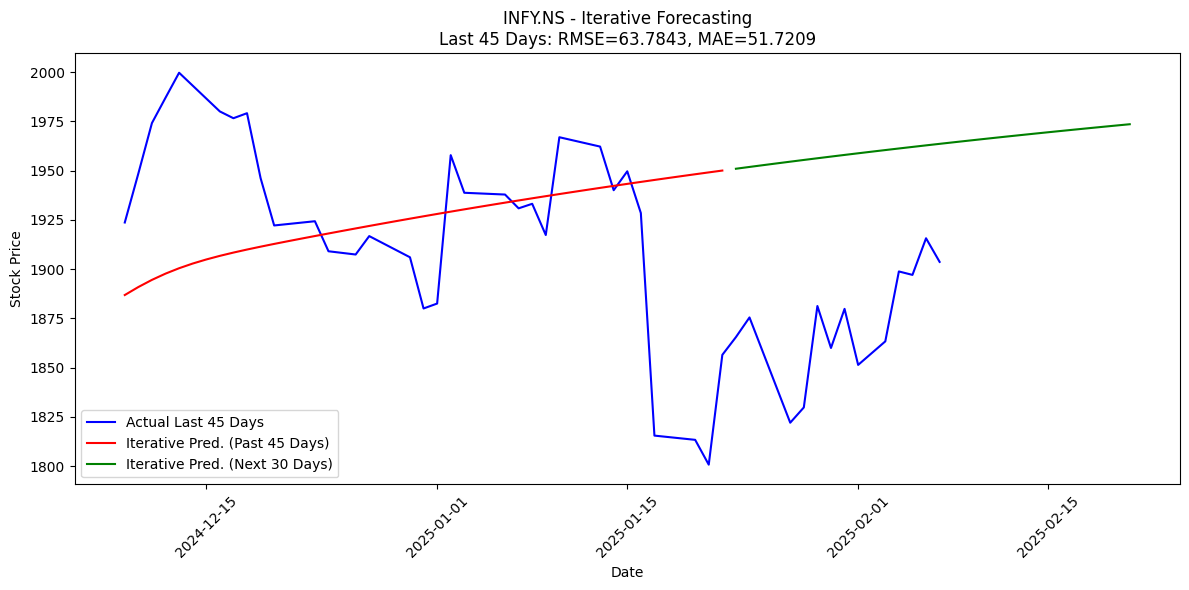

INFY.NS - Last 45 Days Prediction Errors: RMSE = 63.7843, MAE = 51.7209


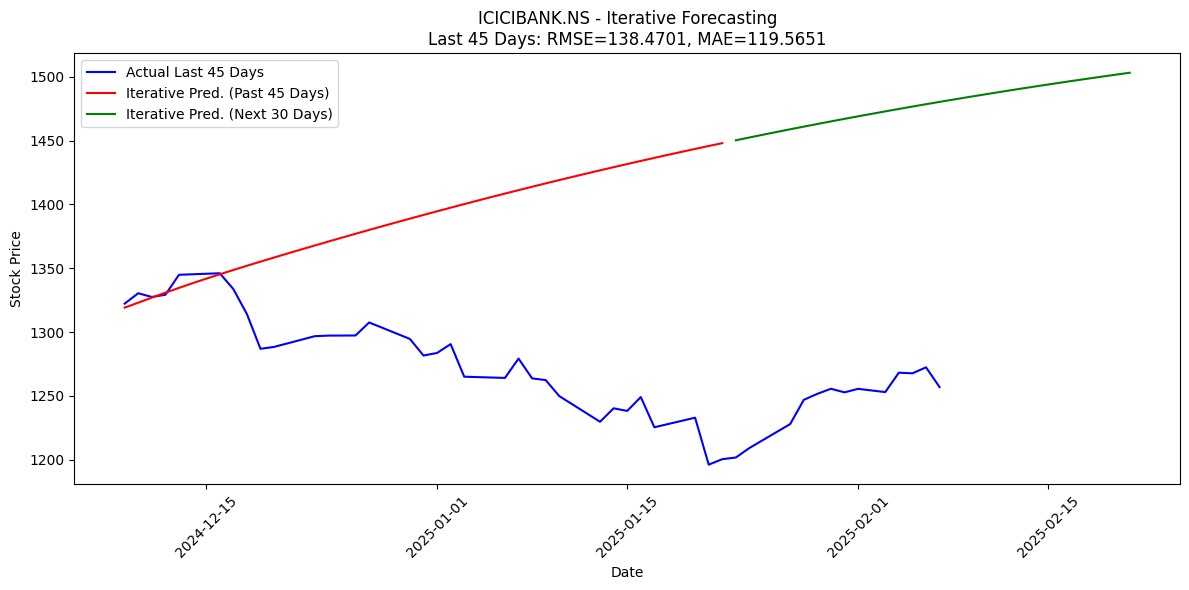

ICICIBANK.NS - Last 45 Days Prediction Errors: RMSE = 138.4701, MAE = 119.5651


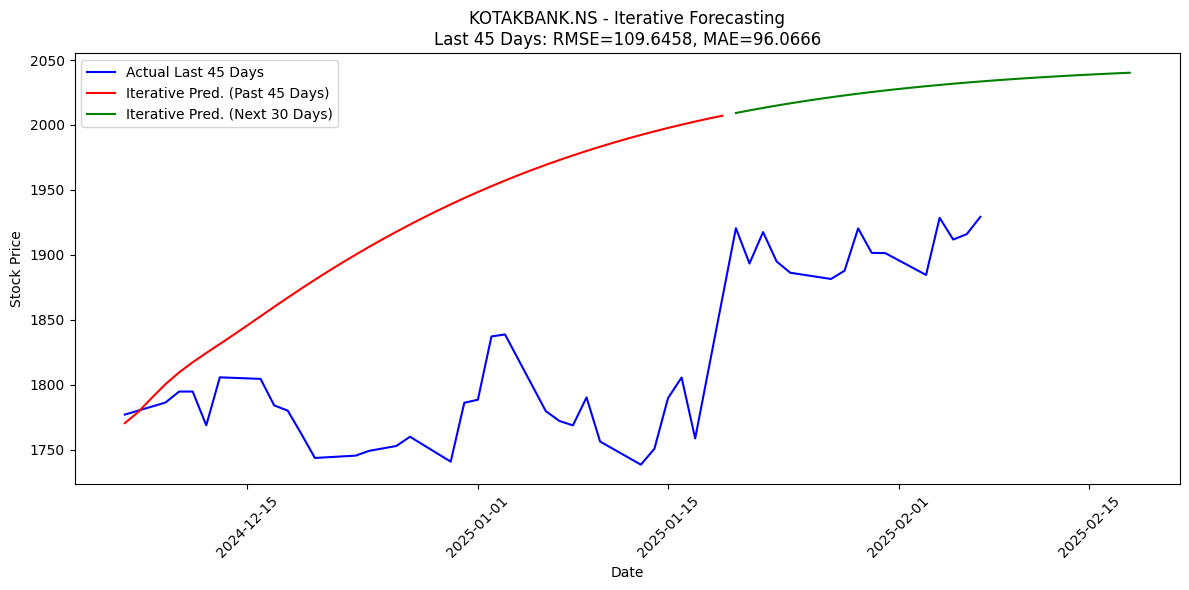

KOTAKBANK.NS - Last 45 Days Prediction Errors: RMSE = 109.6458, MAE = 96.0666


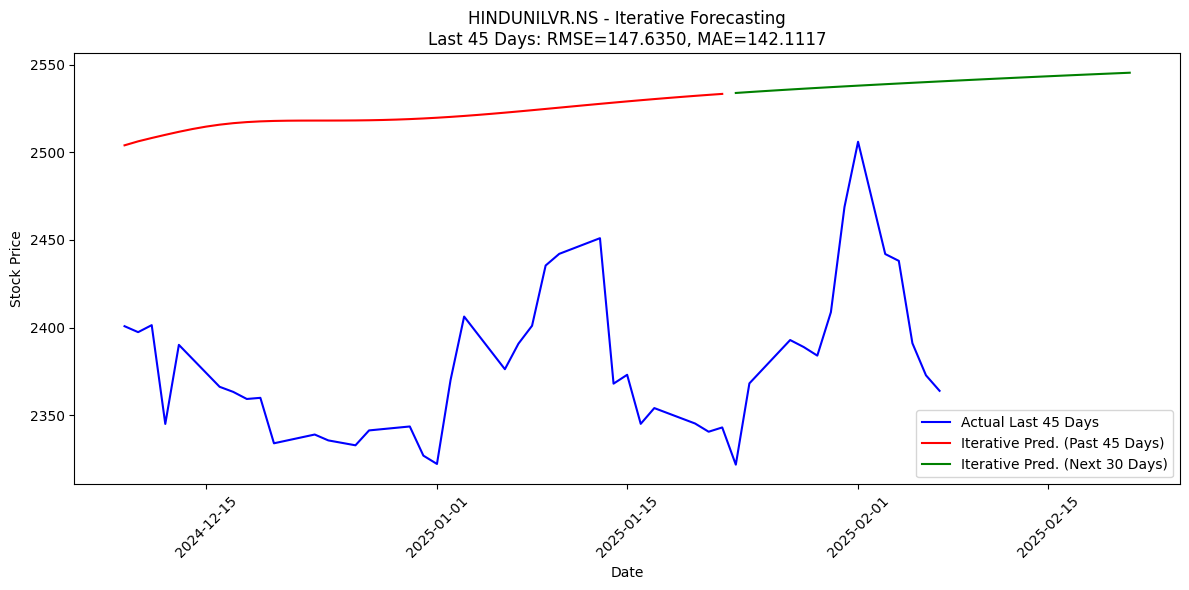

HINDUNILVR.NS - Last 45 Days Prediction Errors: RMSE = 147.6350, MAE = 142.1117


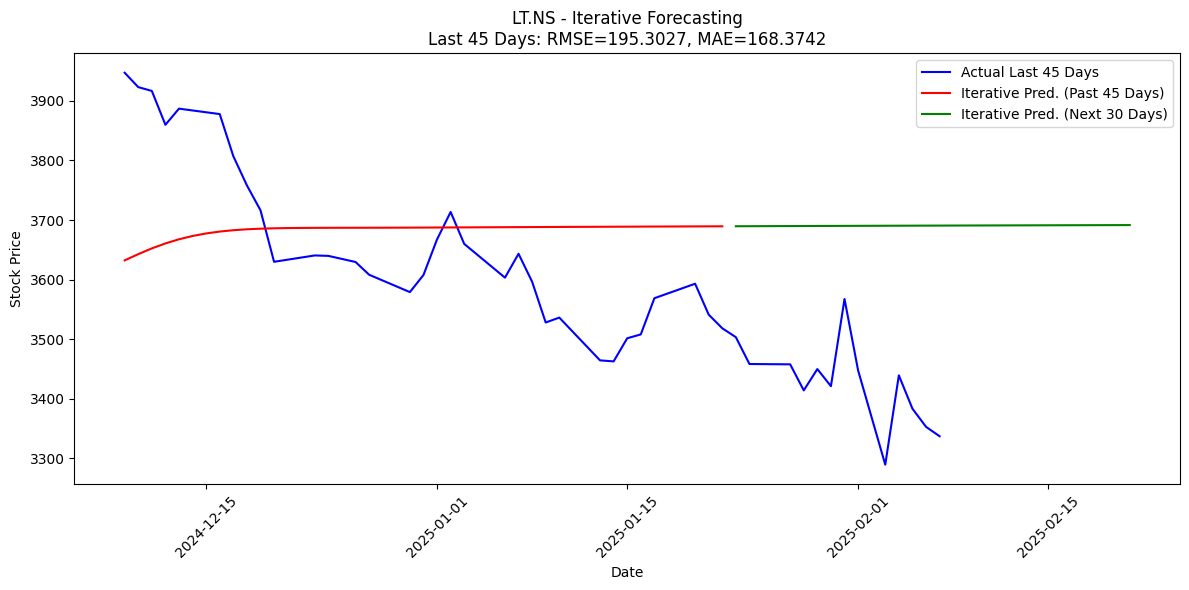

LT.NS - Last 45 Days Prediction Errors: RMSE = 195.3027, MAE = 168.3742


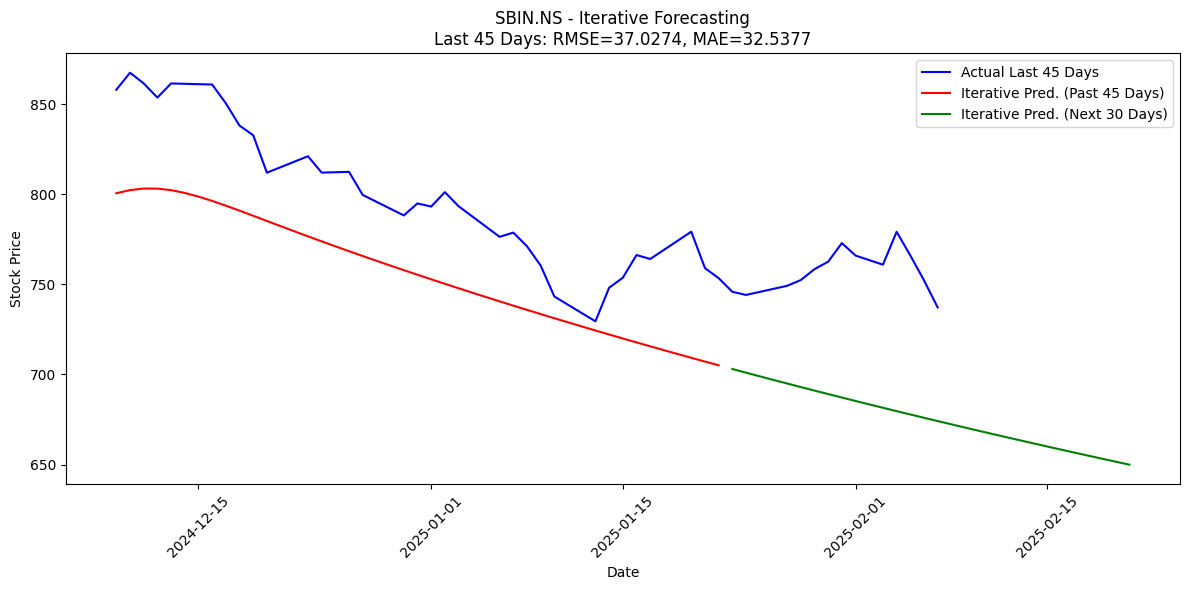

SBIN.NS - Last 45 Days Prediction Errors: RMSE = 37.0274, MAE = 32.5377


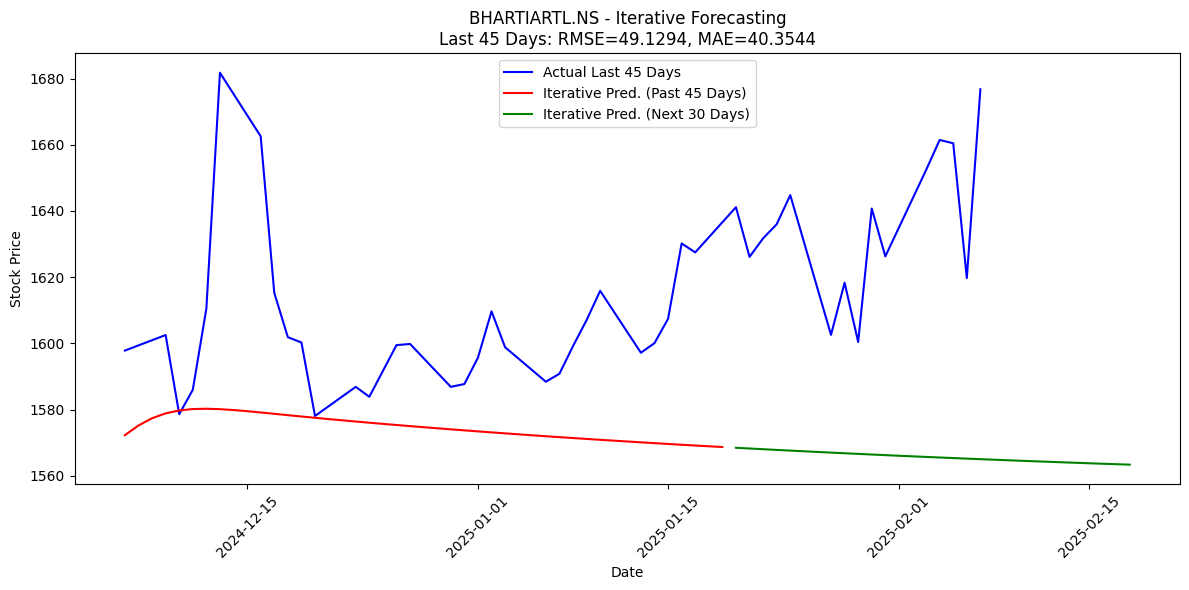

BHARTIARTL.NS - Last 45 Days Prediction Errors: RMSE = 49.1294, MAE = 40.3544


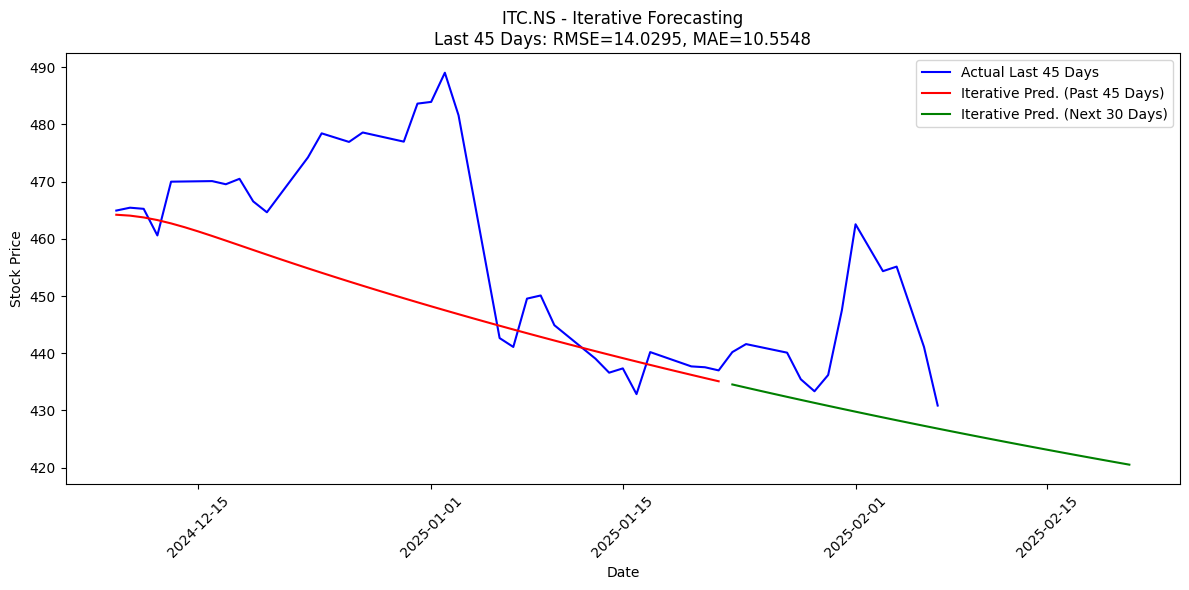

ITC.NS - Last 45 Days Prediction Errors: RMSE = 14.0295, MAE = 10.5548


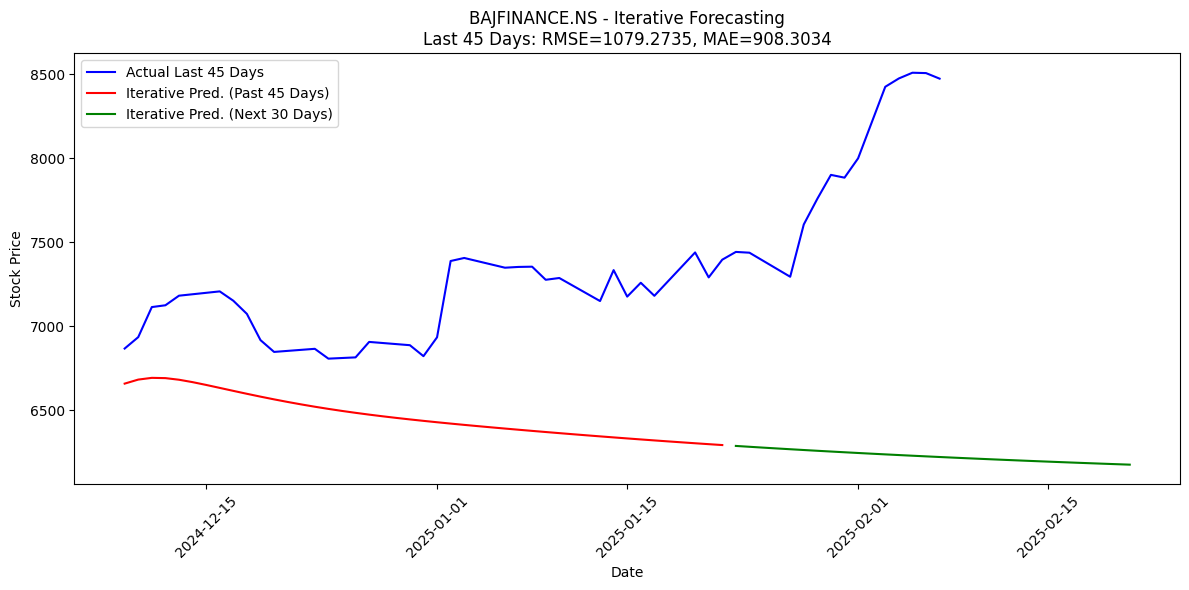

BAJFINANCE.NS - Last 45 Days Prediction Errors: RMSE = 1079.2735, MAE = 908.3034


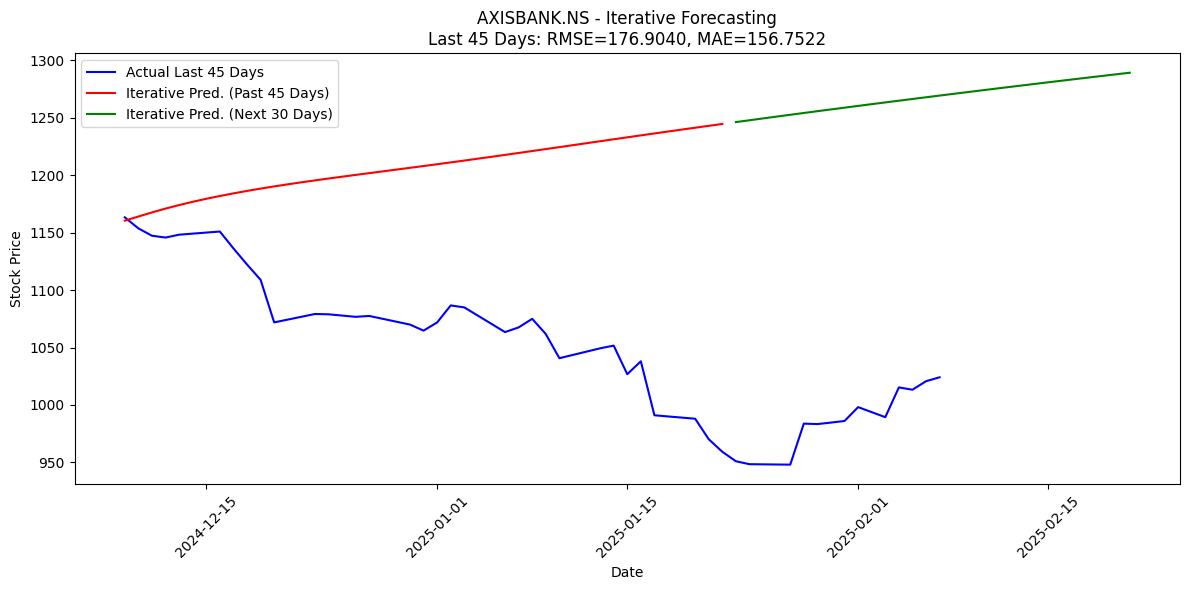

AXISBANK.NS - Last 45 Days Prediction Errors: RMSE = 176.9040, MAE = 156.7522


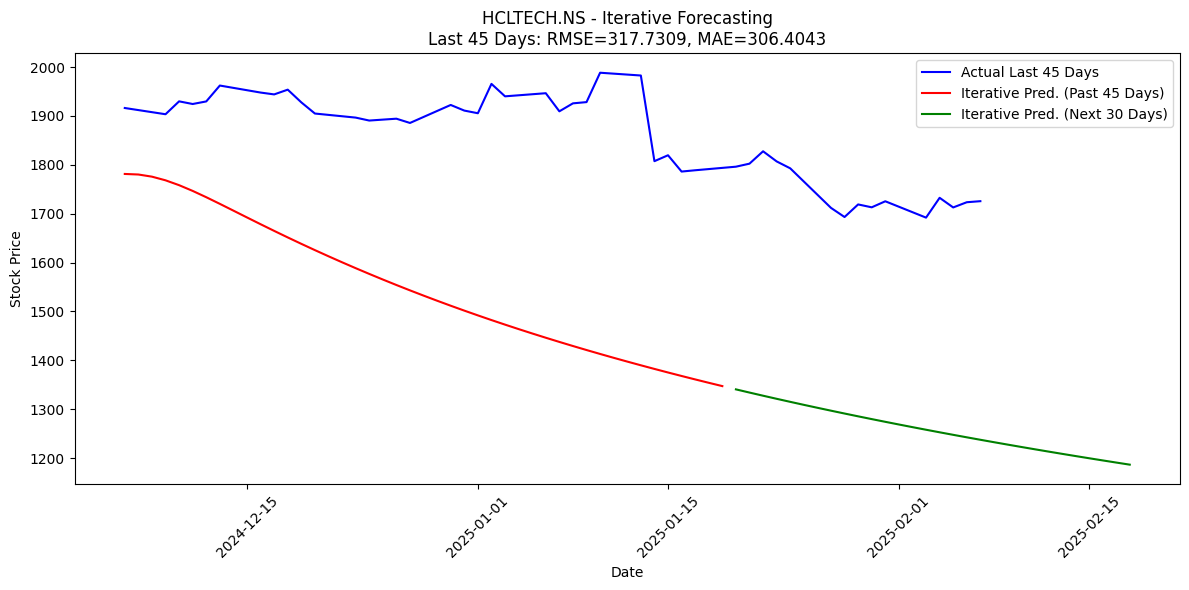

HCLTECH.NS - Last 45 Days Prediction Errors: RMSE = 317.7309, MAE = 306.4043


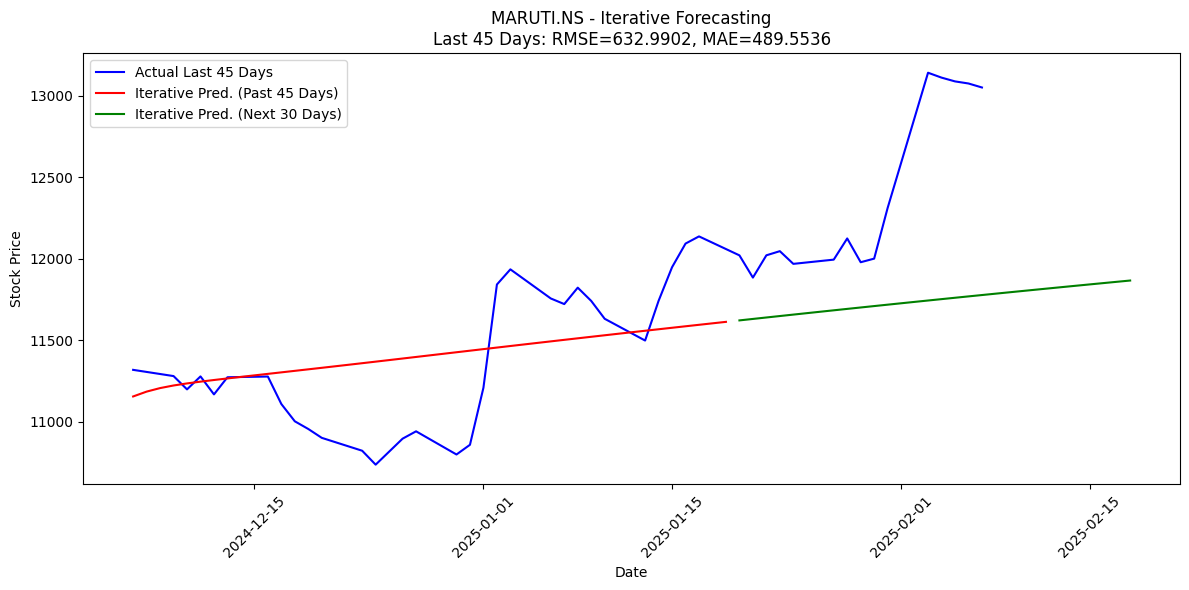

MARUTI.NS - Last 45 Days Prediction Errors: RMSE = 632.9902, MAE = 489.5536


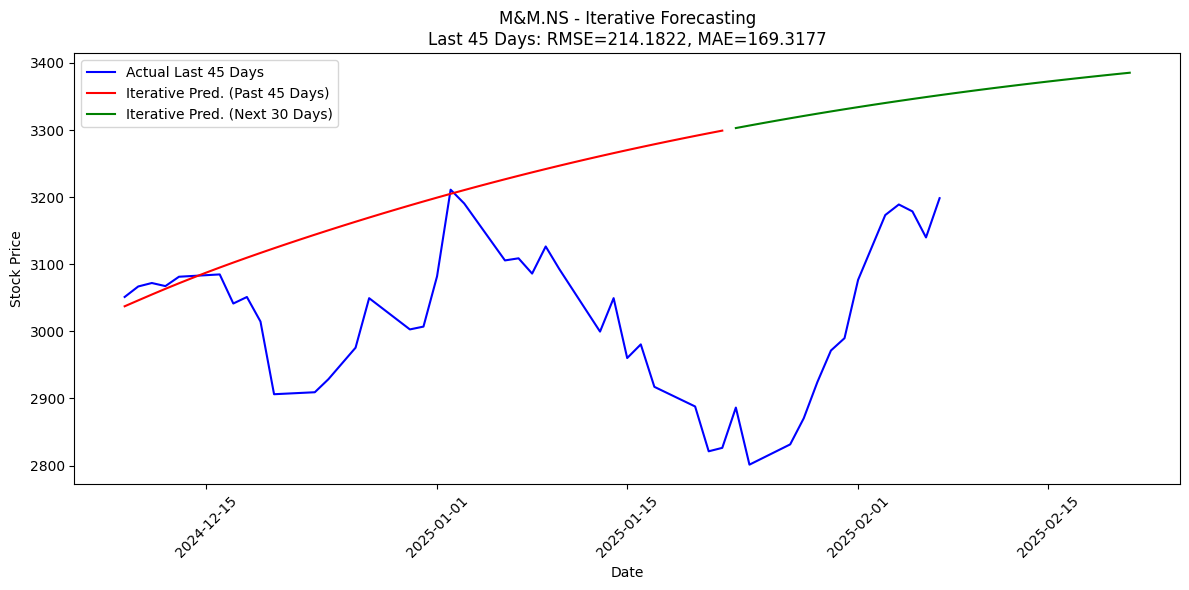

M&M.NS - Last 45 Days Prediction Errors: RMSE = 214.1822, MAE = 169.3177


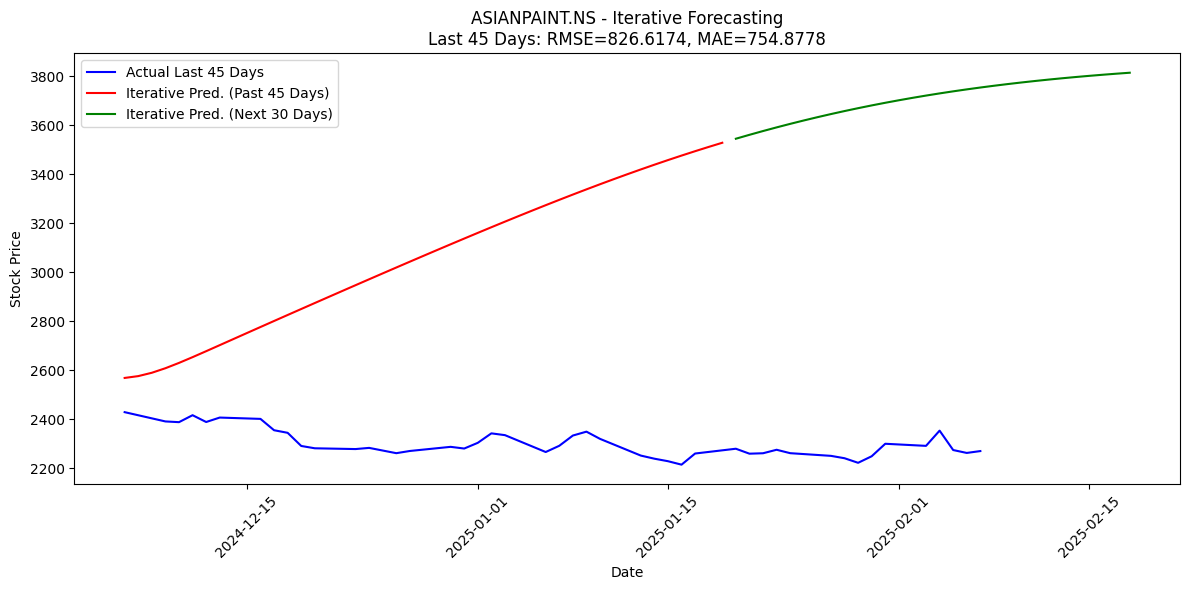

ASIANPAINT.NS - Last 45 Days Prediction Errors: RMSE = 826.6174, MAE = 754.8778


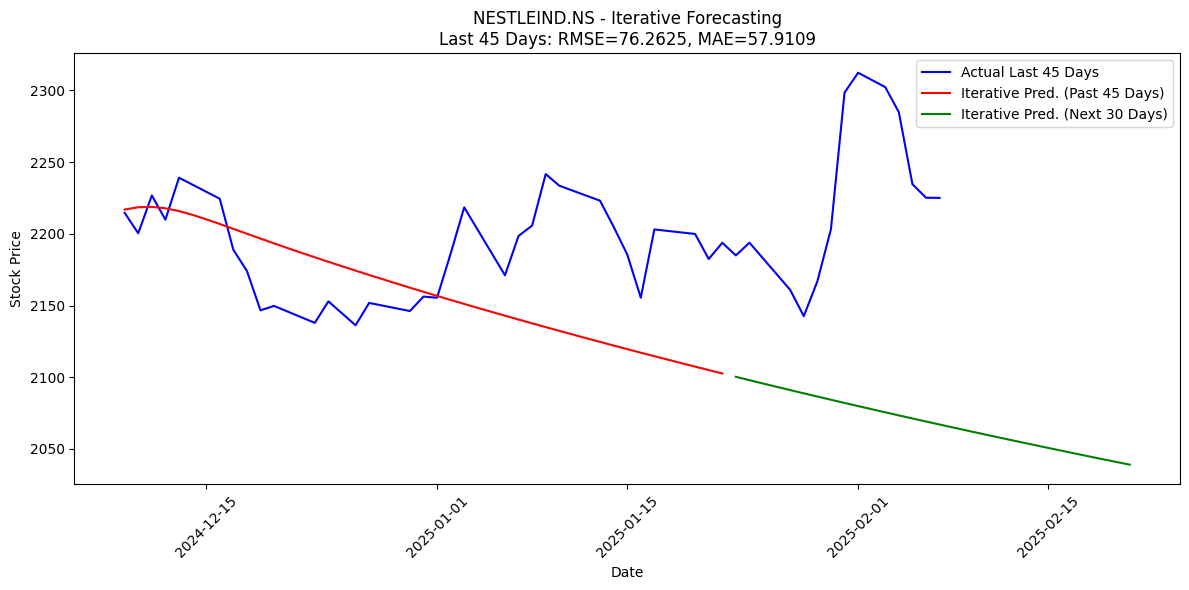

NESTLEIND.NS - Last 45 Days Prediction Errors: RMSE = 76.2625, MAE = 57.9109


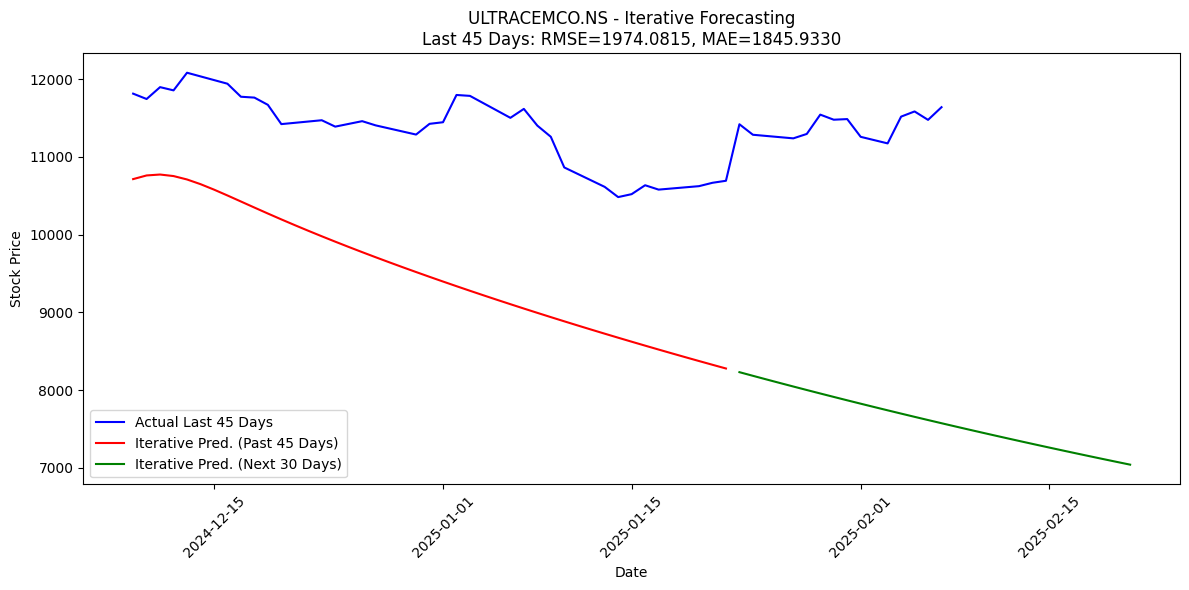

ULTRACEMCO.NS - Last 45 Days Prediction Errors: RMSE = 1974.0815, MAE = 1845.9330


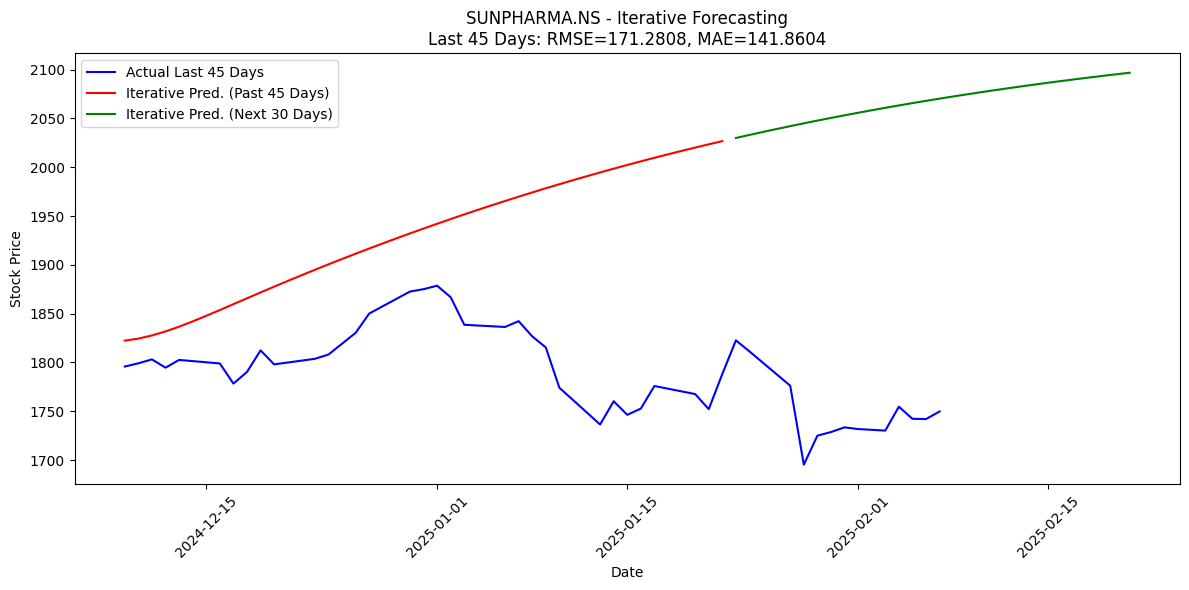

SUNPHARMA.NS - Last 45 Days Prediction Errors: RMSE = 171.2808, MAE = 141.8604


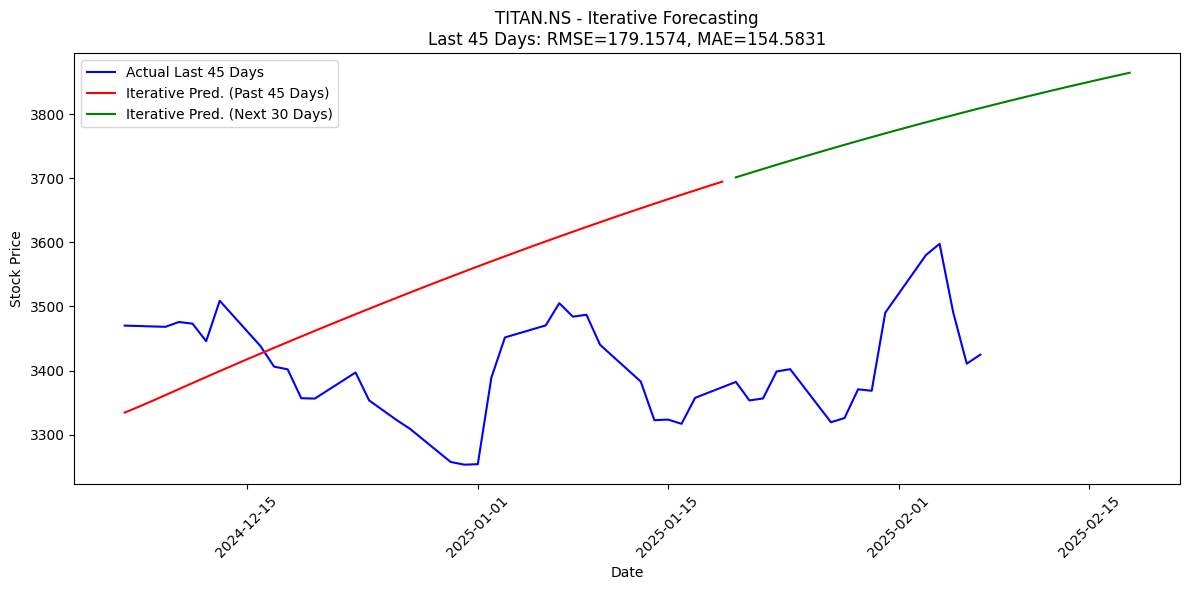

TITAN.NS - Last 45 Days Prediction Errors: RMSE = 179.1574, MAE = 154.5831


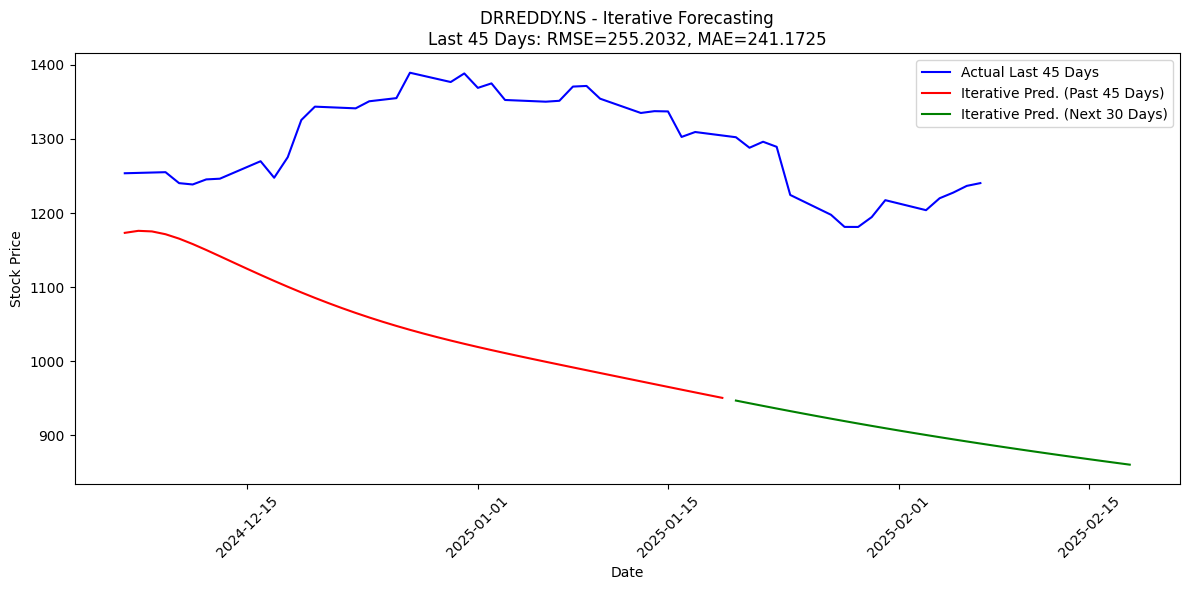

DRREDDY.NS - Last 45 Days Prediction Errors: RMSE = 255.2032, MAE = 241.1725


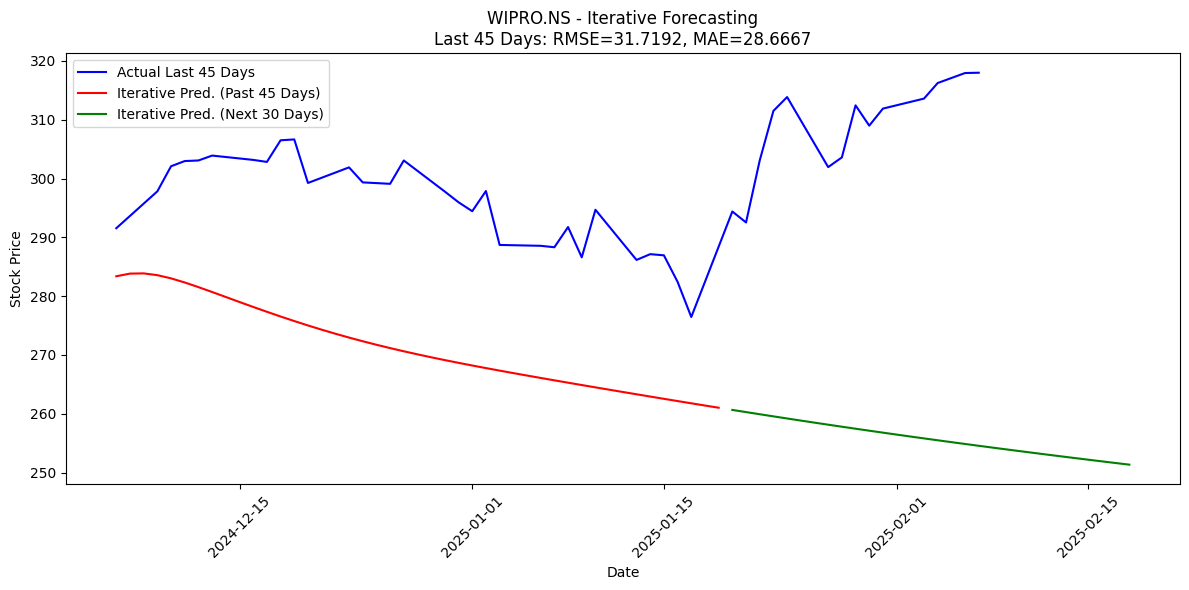

WIPRO.NS - Last 45 Days Prediction Errors: RMSE = 31.7192, MAE = 28.6667


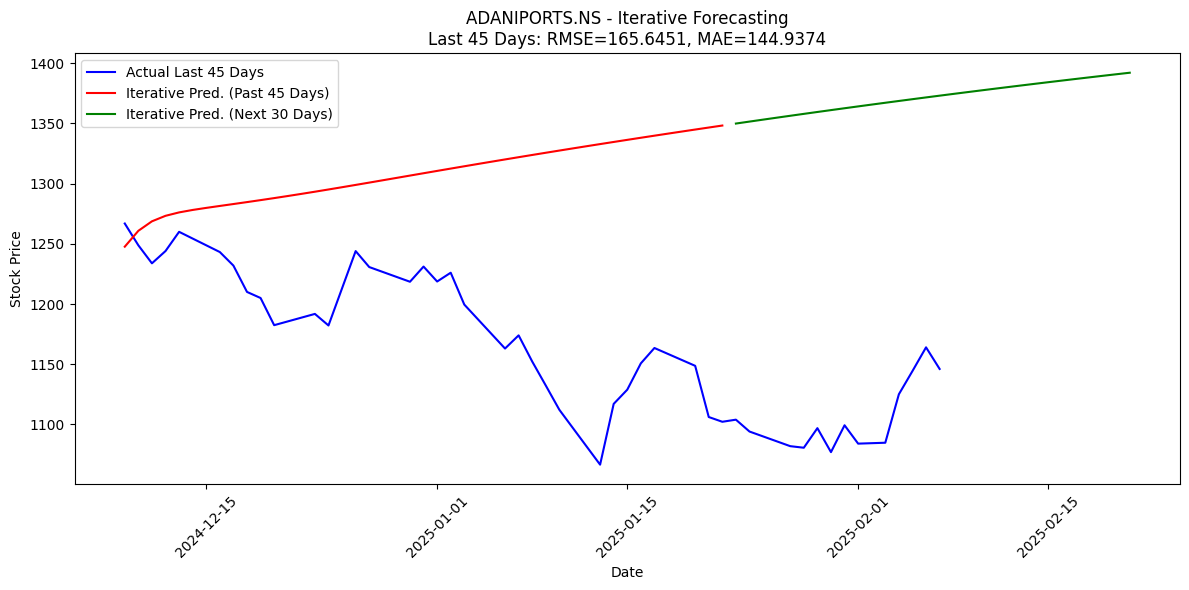

ADANIPORTS.NS - Last 45 Days Prediction Errors: RMSE = 165.6451, MAE = 144.9374


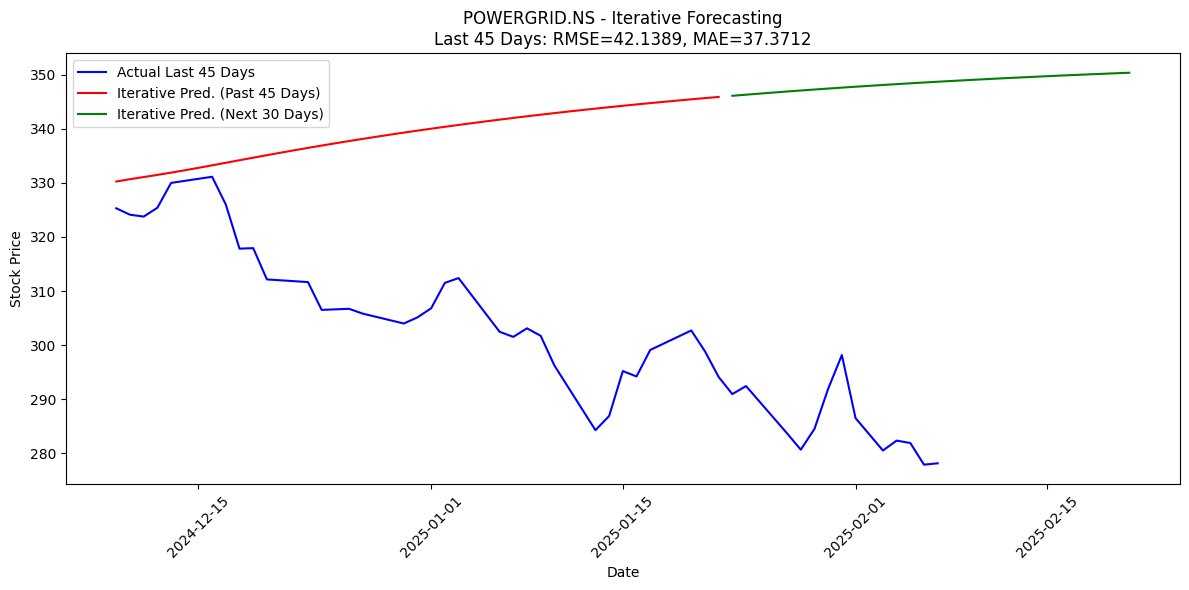

POWERGRID.NS - Last 45 Days Prediction Errors: RMSE = 42.1389, MAE = 37.3712


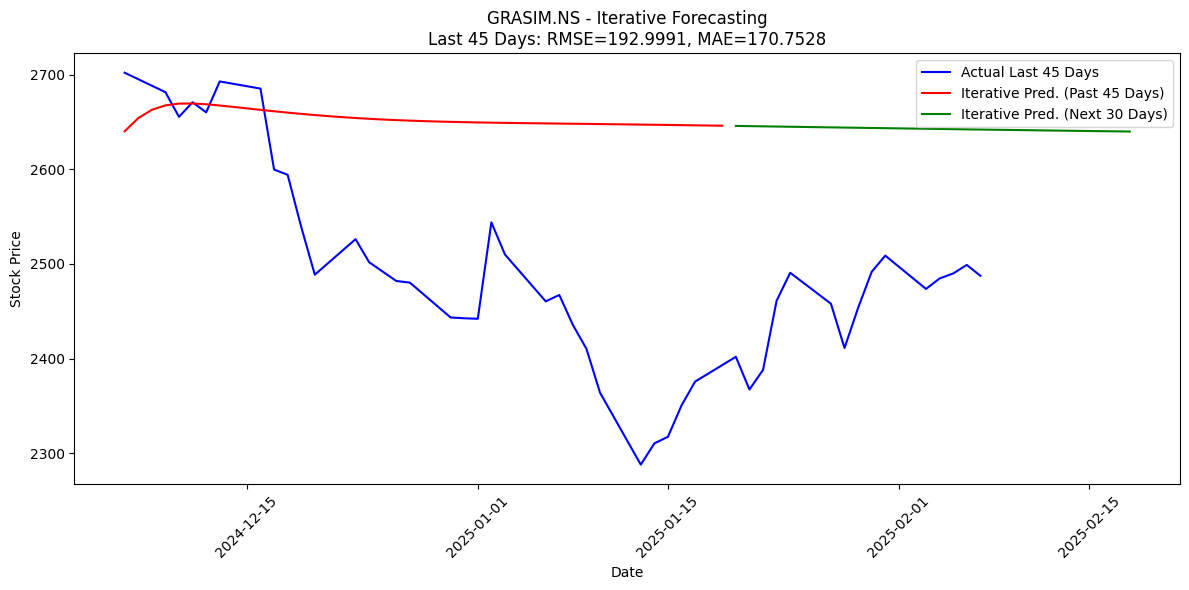

GRASIM.NS - Last 45 Days Prediction Errors: RMSE = 192.9991, MAE = 170.7528


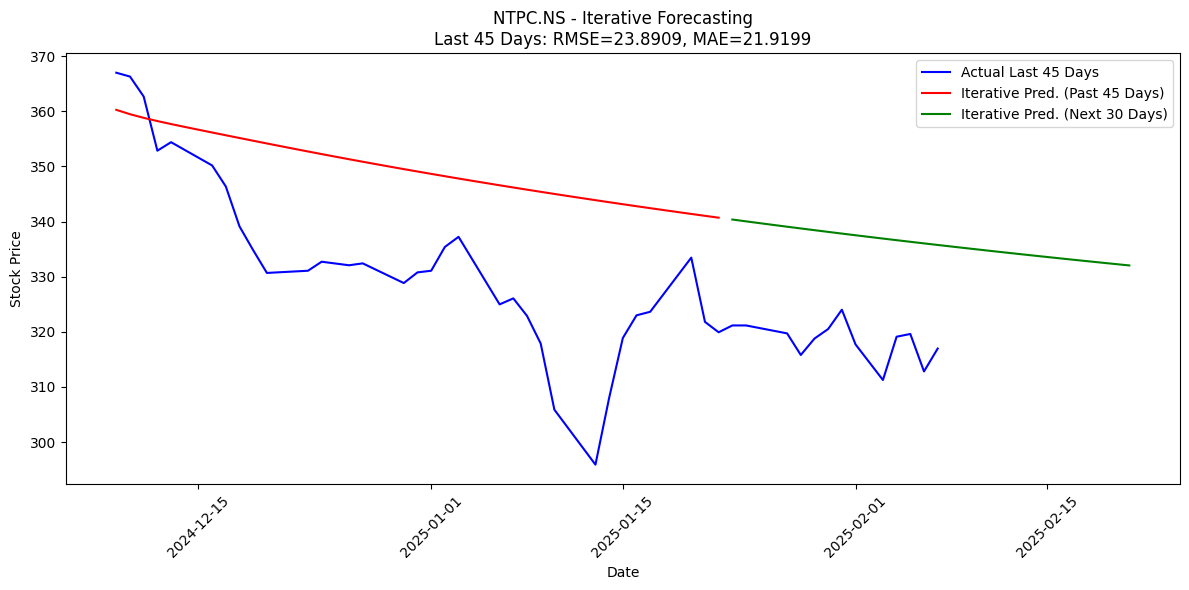

NTPC.NS - Last 45 Days Prediction Errors: RMSE = 23.8909, MAE = 21.9199


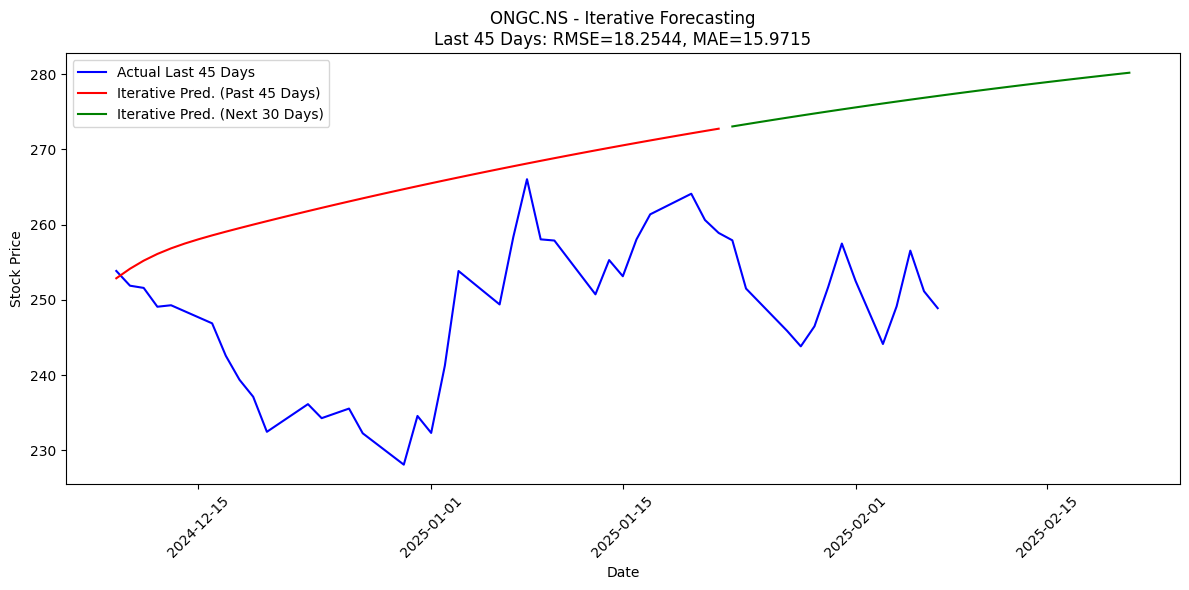

ONGC.NS - Last 45 Days Prediction Errors: RMSE = 18.2544, MAE = 15.9715


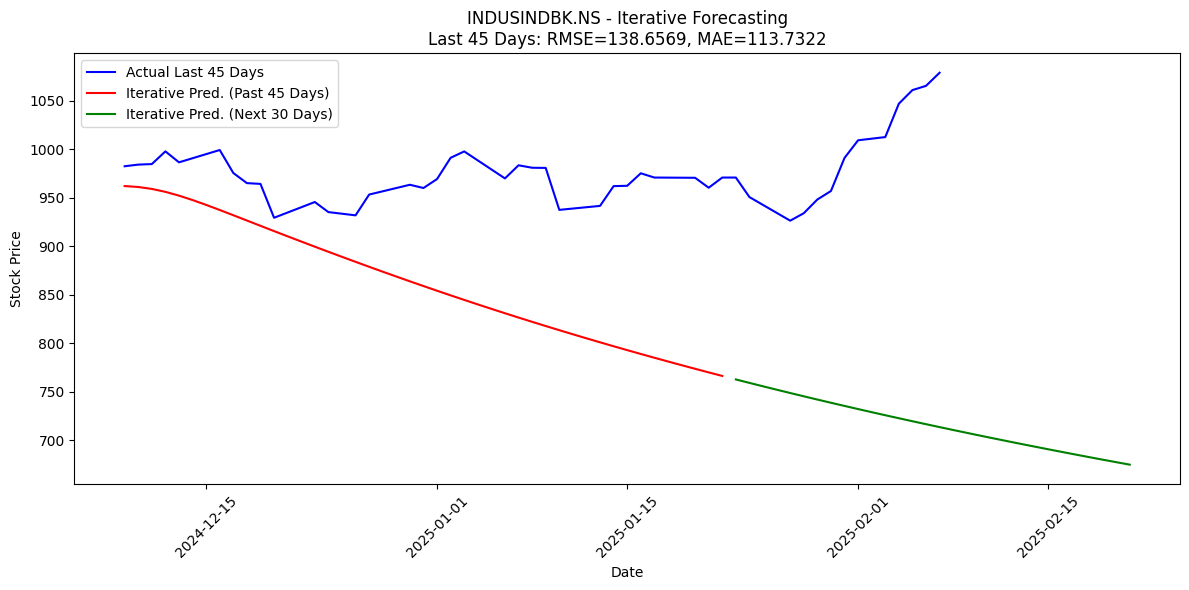

INDUSINDBK.NS - Last 45 Days Prediction Errors: RMSE = 138.6569, MAE = 113.7322


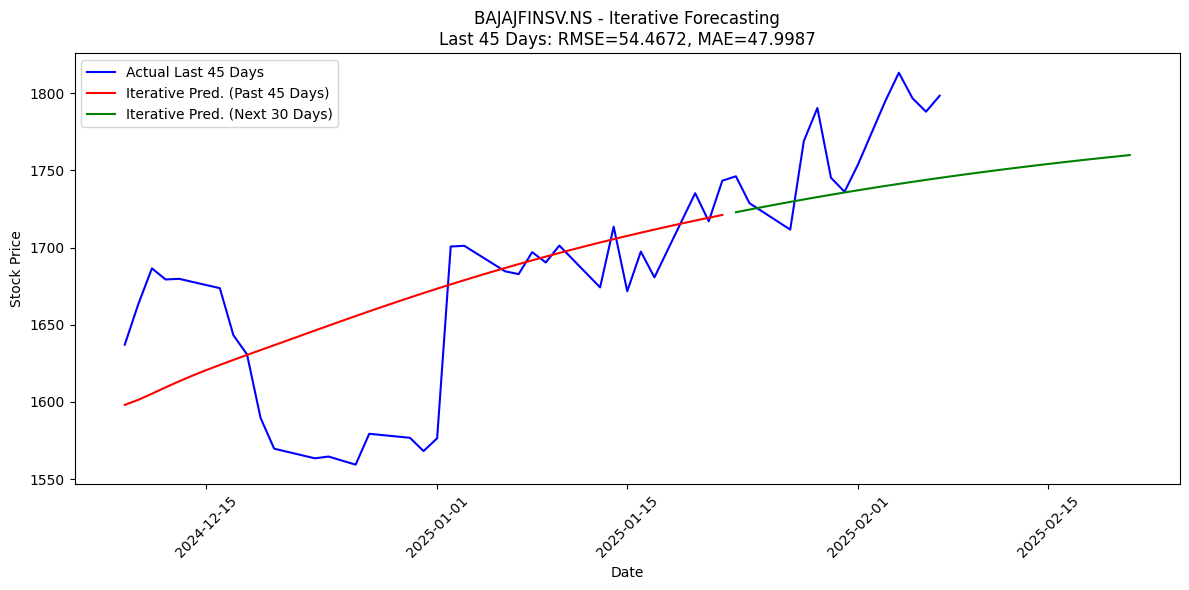

BAJAJFINSV.NS - Last 45 Days Prediction Errors: RMSE = 54.4672, MAE = 47.9987


In [33]:
for ticker, data in stock_sequences.items():
    model = models[ticker]
    scaler = data['scaler']
    dates = pd.to_datetime(data['dates'])  
    X = data['X']  
    y = data['y']  

    actual_last45_dates = dates[-45:]
    actual_last45_values = scaler.inverse_transform(y[-45:].reshape(-1, 1))

    start_index = len(X) - 45 - 1
    current_sequence = X[start_index].copy()  
    
    iterative_preds_45_scaled = []  
    iterative_dates_45 = []         

    iterative_date = dates[-45]

    for i in range(45):
        current_sequence_reshaped = current_sequence.reshape(1, current_sequence.shape[0], 1)
        next_pred_scaled = model.predict(current_sequence_reshaped, verbose=0)
        iterative_preds_45_scaled.append(next_pred_scaled[0, 0])
        iterative_dates_45.append(iterative_date)
        
        current_sequence = np.append(current_sequence[1:], [[next_pred_scaled[0, 0]]], axis=0)
        
        iterative_date = iterative_date + pd.Timedelta(days=1)
    
    iterative_preds_45 = scaler.inverse_transform(np.array(iterative_preds_45_scaled).reshape(-1, 1))
    
    rmse = math.sqrt(mean_squared_error(actual_last45_values, iterative_preds_45))
    mae = mean_absolute_error(actual_last45_values, iterative_preds_45)
    
    iterative_preds_30_scaled = []  
    iterative_dates_30 = []         

    future_date = iterative_date

    for i in range(30):
        current_sequence_reshaped = current_sequence.reshape(1, current_sequence.shape[0], 1)
        next_pred_scaled = model.predict(current_sequence_reshaped, verbose=0)
        iterative_preds_30_scaled.append(next_pred_scaled[0, 0])
        iterative_dates_30.append(future_date)

        current_sequence = np.append(current_sequence[1:], [[next_pred_scaled[0, 0]]], axis=0)
        
        future_date = future_date + pd.Timedelta(days=1)
    
    iterative_preds_30 = scaler.inverse_transform(np.array(iterative_preds_30_scaled).reshape(-1, 1))

    plt.figure(figsize=(12, 6))
    
    plt.plot(actual_last45_dates, actual_last45_values, label='Actual Last 45 Days', color='blue')
    
    plt.plot(iterative_dates_45, iterative_preds_45, label='Iterative Pred. (Past 45 Days)', color='red')
    
    plt.plot(iterative_dates_30, iterative_preds_30, label='Iterative Pred. (Next 30 Days)', color='green')
    
    plt.title(f"{ticker} - Iterative Forecasting\nLast 45 Days: RMSE={rmse:.4f}, MAE={mae:.4f}")
    plt.xlabel("Date")
    plt.ylabel("Stock Price")
    plt.xticks(rotation=45)
    plt.legend()
    plt.tight_layout()
    plt.show()
    
    print(f"{ticker} - Last 45 Days Prediction Errors: RMSE = {rmse:.4f}, MAE = {mae:.4f}")